Instalacion de librerias y dependencias

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [2]:
WORKSPACE_PATH = 'Tensorflow/workspace'
SCRIPTS_PATH= 'Tensorflow/scripts'

In [3]:
APIMODEL_PATH = 'Tensorflow/models' 
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations' 
IMAGE_PATH = WORKSPACE_PATH+'/images' 
MODEL_PATH = WORKSPACE_PATH+'/models' 
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models' 
CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet/pipeline.config' 
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet/'

In [4]:
#variable para alojar el modelo de mediapipe holistic
mp_holistic = mp.solutions.holistic
#variable para alojar el modelo de mp drawing
mp_drawing=mp.solutions.drawing_utils

#mediapipe detection
def mediapipe_detection (image,model):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image,results
#hasta aqui

In [5]:
def draw_changed_landmarks(image,results):
    #Para dibujar los landmarks de las caras
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, mp_drawing.DrawingSpec(color=(191,95,0),thickness=1,circle_radius=1), mp_drawing.DrawingSpec(color=(237,178,101),thickness=1,circle_radius=0.5))
    #Dibujar landmarks de la postura
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(3,56,172), thickness=2,circle_radius=3), mp_drawing.DrawingSpec(color=(141,241,244),thickness=2,circle_radius=3))
    #Dibujar landmarks de left Hand
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, mp_drawing.DrawingSpec(color=(3,89,17),thickness=2,circle_radius=3), mp_drawing.DrawingSpec(color=(134,242,196),thickness=3,circle_radius=2))
    # Para dibujar los landmarks de la mano derecha (con sus conexiones) 
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, mp_drawing.DrawingSpec(color=(134,242,196), thickness=2,circle_radius=3), mp_drawing.DrawingSpec(color=(3,89,17), thickness=3, circle_radius=2))

CAPTURANDO IMAGENES POR CAMARA

In [6]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        #Leyendo feed
        ret,frame= cap.read()

        #Deteccion(entre el feed y renderizado)
        image,results = mediapipe_detection(frame,holistic)
        print(results)

        #dibujar landmarks en la imagen capturada
        draw_changed_landmarks(image,results)

        #presentar en ventana
        cv2.imshow('Pantalla OpenCV',image)
        #para salir del loop presiona q o Q
        if cv2.waitKey(1) & 0xFF == ((ord('q'))or ((ord('Q')))):
            break
cap.release()
cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

EXTRAER KEYPOINTS

In [6]:
def extract_keypoints(resutls): 
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in 
        results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4) 
    face = np.array([[res.x, res.y, res.z] for res in 
        results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)  
    lh = np.array([[res.x, res.y, res.z] for res in 
        results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)  
    rh = np.array([[res.x, res.y, res.z] for res in 
        results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)  
    return np.concatenate([pose, face, lh, rh])

CONFIGURACION DE DIRECTORIOS PARA LA COLECCION DE LOS ARREGLOS

In [7]:
# Ruta para los datos exportados, arreglos numpy 
DATA_PATH = os.path.join('Datos_Dataset_3') 
    # Acciones (5) a detectar 
actions = np.array(['Hola','Gracias','Comprendo','Como estas','De nada']) 
    # 125 'videos' de datos (por seña) 
no_sequences = 125  
    # Tamaño/longitud de los videos (en frames) 
sequence_length = 30 
### 
for action in actions: 
    for sequence in range(no_sequences): 
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence))) 
        except: 
            pass 

RECOLECCION DE KEYPOINTS PARA TRAINING Y TESTING

In [19]:
cap = cv2.VideoCapture(0) 
#
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic: 
#Loop por cada accion
    for action in actions:  
    #Loop por secuencia/video 
        for sequence in range(no_sequences): 
        # Loop por frame (según longitud del video/ la secuencia) 
            for frame_num in range(sequence_length): 
#
   #Leyendo el feed 
                ret, frame = cap.read()
    #
                #Detección (entre feed y renderizado) 
                image, results = mediapipe_detection(frame, holistic) 
                print(results) 
#
#Dibujar landmarks (entre la detección y el display) 
                draw_changed_landmarks(image, results)
                  #Tiempo de espera entre capturas 
                if frame_num == 0: 
                    cv2.putText(image, 'COMENZANDO RECOLECCIÓN', (120,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3, cv2.LINE_AA) 
                    cv2.putText(image, 'Recolectando frames para {} numero de video {}'.format(action, sequence), (15,12), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.waitKey(2000) #2 segundos
                else:
                    cv2.putText(image, 'Recolectando frames para {} numero de video {}'.format(action, sequence), (15,12), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                  # Exportar keypoints (extraerlos y guardarlos en las carpetas) 
                keypoints = extract_keypoints(results) #results de la función de detección MP
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
    # Dónde se guarda el frame y su nombre 
                np.save(npy_path, keypoints) 
                    #Presentar en pantalla 
                cv2.imshow('Pantalla OpenCV', image) 
                    #Para la "current key", sale del loop 
                if cv2.waitKey(10) & 0xFF == ((ord('q'))or ((ord('Q')))): 
                    break 
cap.release() 
cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

PREPROCESAMIENTO DE LOS DATOS Y CREACION DE ETIQUETAS Y FEATURES

<h1>Data Augmentation</h1>

<h2>LOS 4 TIPOS D DATA AUGMENTATION</h2>

In [8]:
DATA_PATH_AUG = os.path.join('Datos_Dataset_Aug_AllFour') 

In [9]:
import mediapipe as mp
import numpy as np
import random
import math
from scipy.spatial.transform import Rotation as R

def __random_pass(prob):
    # Función auxiliar que devuelve True con una probabilidad dada.
    return random.random() < prob
    
#85% de las veces pq la transformacion es sutil
def rotate_point_2d(point, center, angle_rad):
    # Rota un punto 2D alrededor de un centro dado por un ángulo en radianes.
    x, y = point
    cx, cy = center
    rotated_x = cx + math.cos(angle_rad) * (x - cx) - math.sin(angle_rad) * (y - cy)
    rotated_y = cy + math.sin(angle_rad) * (x - cx) + math.cos(angle_rad) * (y - cy)
    return np.array([rotated_x, rotated_y])

def rotate_hand_in_plane(landmarks, angle_range_deg=(-20, 20)):
    # Aplica una rotación en el plano (alrededor del eje z) a los landmarks de la mano.
    angle_deg = random.uniform(*angle_range_deg)
    angle_rad = math.radians(angle_deg)
    rotated_landmarks = landmarks.copy()
    # El centro de rotación se establece como la muñeca (índice 0).
    center = landmarks[0, :2].copy()
    for i in range(landmarks.shape[0]):
        rotated_landmarks[i, :2] = rotate_point_2d(landmarks[i, :2], center, angle_rad)
    return rotated_landmarks

#una probabilidad mas baja, si se puede deformar extremamente...
def squeeze_hand_landmarks(landmarks, squeeze_factor_range=(0.85, 1.15)): #se moveran de un 85% a 115% de su distacia con respecto a x o y 
    # Aplica un factor de "estiramiento" o "compresión" a los landmarks de la mano.
    factor_x = random.uniform(*squeeze_factor_range)
    factor_y = random.uniform(*squeeze_factor_range)
    squeezed_landmarks = landmarks.copy()
    # El centro de escalado se establece como la muñeca.
    center_x = landmarks[0, 0]
    center_y = landmarks[0, 1]
    squeezed_landmarks[:, 0] = center_x + (squeezed_landmarks[:, 0] - center_x) * factor_x
    squeezed_landmarks[:, 1] = center_y + (squeezed_landmarks[:, 1] - center_y) * factor_y
    return squeezed_landmarks
    
#puedo eliminar el range y utilizar un valor maximo 
def perspective_transform_hand_landmarks(landmarks, perspective_factor_range=(0.008, 0.025)):
    # Aplica una transformación de perspectiva a los landmarks de la mano.
    factor_x = random.uniform(-perspective_factor_range[1], perspective_factor_range[1])
    factor_y = random.uniform(-perspective_factor_range[1], perspective_factor_range[1])
    transformed_landmarks = landmarks.copy()
    # El centro para la transformación de perspectiva se establece como la muñeca.
    center_x = landmarks[0, 0]
    center_y = landmarks[0, 1]
    transformed_landmarks[:, 0] = transformed_landmarks[:, 0] + (transformed_landmarks[:, 1] - center_y) * factor_x
    transformed_landmarks[:, 1] = transformed_landmarks[:, 1] + (transformed_landmarks[:, 0] - center_x) * factor_y
    return transformed_landmarks

def rotate_finger_joint_sequential(landmarks, base_joint_index, tip_joint_index, angle_range_deg=(-15, 15)):
    # Rota la articulación distal de un dedo alrededor de la articulación proximal.
    rotated_landmarks = landmarks.copy()
    angle_deg = random.uniform(*angle_range_deg)
    angle_rad = math.radians(angle_deg)
    origin = landmarks[base_joint_index, :3].copy()  # Articulación alrededor de la cual rotar
    point_to_rotate = landmarks[tip_joint_index, :3].copy()
    relative_point = point_to_rotate - origin
    # Rotación alrededor del eje z (in-plane)
    rotation_vector = np.array([0, 0, 1]) * angle_rad
    rotation = R.from_rotvec(rotation_vector)
    rotated_relative_point = rotation.apply(relative_point)
    rotated_landmarks[tip_joint_index, :3] = origin + rotated_relative_point
    return rotated_landmarks

def apply_hand_data_augmentation(keypoints):
    # Aplica data augmentation solo a los landmarks de las manos.
    augmented_keypoints = keypoints.copy()
    lh_start = 33 * 4 + 468 * 3  # Inicio de los landmarks de la mano izquierda
    lh_end = lh_start + 21 * 3    # Fin de los landmarks de la mano izquierda
    rh_start = lh_end             # Inicio de los landmarks de la mano derecha
    rh_end = rh_start + 21 * 3    # Fin de los landmarks de la mano derecha

    lh_landmarks = keypoints[lh_start:lh_end].reshape(21, 3) if keypoints.shape[0] >= rh_end else None
    rh_landmarks = keypoints[rh_start:rh_end].reshape(21, 3) if keypoints.shape[0] >= rh_end else None

    augmented_lh = lh_landmarks.copy() if lh_landmarks is not None else None
    augmented_rh = rh_landmarks.copy() if rh_landmarks is not None else None

    # Data Augmentation para la Mano Izquierda
    if augmented_lh is not None:
        # Rotación en el plano, probabilidad del 85%
        if __random_pass(0.85):
            augmented_lh[:, :2] = rotate_hand_in_plane(augmented_lh[:, :2])
        
        # Squeeze, probabilidad del 60% 
        if __random_pass(0.60):
            augmented_lh[:, :2] = squeeze_hand_landmarks(augmented_lh[:, :2])
        
        # Transformación de perspectiva
        if __random_pass(0.60):
            augmented_lh[:, :2] = perspective_transform_hand_landmarks(augmented_lh[:, :2])
        
        # Rotación secuencial de las articulaciones de los dedos (punta alrededor de DIP)
        for base_joint in [5, 9, 13, 17]:  # MCP de índice, medio, anular, meñique
            if __random_pass(0.85):
                augmented_lh = rotate_finger_joint_sequential(augmented_lh, base_joint + 2, base_joint + 3) # DIP a TIP

    # Data Augmentation para la Mano Derecha
    if augmented_rh is not None:
        # Rotación en el plano
        if __random_pass(0.85):
            augmented_rh[:, :2] = rotate_hand_in_plane(augmented_rh[:, :2])
        
        # Squeeze
        if __random_pass(0.60):
            augmented_rh[:, :2] = squeeze_hand_landmarks(augmented_rh[:, :2])
        
        # Transformación de perspectiva
        if __random_pass(0.60):
            augmented_rh[:, :2] = perspective_transform_hand_landmarks(augmented_rh[:, :2])
        
        # Rotación secuencial de las articulaciones de los dedos (punta alrededor de DIP)
        for base_joint in [5, 9, 13, 17]:  # MCP de índice, medio, anular, meñique
            if __random_pass(0.85):
                augmented_rh = rotate_finger_joint_sequential(augmented_rh, base_joint + 2, base_joint + 3) # DIP a TIP

    # Reemplazar los keypoints originales de las manos con los aumentados
    if augmented_lh is not None:
        augmented_keypoints[lh_start:lh_end] = augmented_lh.flatten()
    if augmented_rh is not None:
        augmented_keypoints[rh_start:rh_end] = augmented_rh.flatten()

    return augmented_keypoints

#la funcion recorre las carpetas de las 125 secuencias y aumenta cada frame de cada secuencia supuestamente
def apply_augmentation_to_sequence(input_sequence_path, output_sequence_path):
    """
    Itera sobre los frames de una secuencia, aplica data augmentation a las manos
    y guarda la secuencia aumentada en una nueva carpeta.
    """
    os.makedirs(output_sequence_path, exist_ok=True)
    for frame_num in range(sequence_length):
        frame_path = os.path.join(input_sequence_path, f'{frame_num}.npy')
        try:
            keypoints_original = np.load(frame_path)
            keypoints_augmented = apply_hand_data_augmentation(keypoints_original) 
            output_frame_path = os.path.join(output_sequence_path, f'{frame_num}.npy')
            np.save(output_frame_path, keypoints_augmented)
        except FileNotFoundError:
            print(f"Archivo no encontrado: {frame_path}")

In [10]:
#el for para que empiece a iterar
# Iterar sobre cada acción (seña)
for action in actions:
    action_path = os.path.join(DATA_PATH_NORM, action)
    output_path = os.path.join(DATA_PATH_AUG,action)
    # Iterar sobre las secuencias originales para esta acción
    for sequence_num in range(no_sequences):
        input_sequence_dir = os.path.join(action_path, str(sequence_num))
        output_sequence_dir = os.path.join(output_path, str(sequence_num + no_sequences)) # Secuencias aumentadas empiezan después de las originales

        if os.path.exists(input_sequence_dir):
            print(f"Aplicando aumentación a la secuencia: {sequence_num} de '{action}', guardando como: {sequence_num + no_sequences}")
            apply_augmentation_to_sequence(input_sequence_dir, output_sequence_dir) # No augment_probability
        else:
            print(f"Secuencia original no encontrada: {input_sequence_dir}")

print("Proceso de aumentación completado. Las secuencias aumentadas se guardaron en las carpetas de cada seña.")

NameError: name 'DATA_PATH_NORM' is not defined

In [20]:
#el for para que empiece a iterar
# Iterar sobre cada acción (seña)

for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    output_path = os.path.join(DATA_PATH_AUG,action)
    # Iterar sobre las secuencias originales para esta acción
    for sequence_num in range(no_sequences):
        input_sequence_dir = os.path.join(action_path, str(sequence_num))
        output_sequence_dir = os.path.join(output_path, str(sequence_num + no_sequences)) # Secuencias aumentadas empiezan después de las originales

        if os.path.exists(input_sequence_dir):
            print(f"Aplicando aumentación a la secuencia: {sequence_num} de '{action}', guardando como: {sequence_num + no_sequences}")
            apply_augmentation_to_sequence_r(input_sequence_dir, output_sequence_dir) # No augment_probability
        else:
            print(f"Secuencia original no encontrada: {input_sequence_dir}")

print("Proceso de aumentación completado. Las secuencias aumentadas se guardaron en las carpetas de cada seña.")

Aplicando aumentación a la secuencia: 0 de 'Hola', guardando como: 125


NameError: name 'apply_augmentation_to_sequence_r' is not defined

In [20]:
#el for para que empiece a iterar
# Iterar sobre cada acción (seña)
#PARA SOLO APLCAR EN EL FRAME QUE SE QUE SRVE
sequence_num = 35
no_sequence= 125
for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    input_sequence_dir = os.path.join(action_path, str(sequence_num))
    output_sequence_dir = os.path.join(action_path, str(sequence_num + no_sequence)) # Secuencias aumentadas empiezan después de las originales
    if os.path.exists(input_sequence_dir):
        print(f"Aplicando aumentación a la secuencia: {sequence_num} de '{action}', guardando como: {sequence_num + no_sequences}")
        apply_augmentation_to_sequence(input_sequence_dir, output_sequence_dir) # No augment_probability
    else:
        print(f"Secuencia original no encontrada: {input_sequence_dir}")

print("Proceso de aumentación completado. Las secuencias aumentadas se guardaron en las carpetas de cada seña.")

Aplicando aumentación a la secuencia: 35 de 'hola', guardando como: 160
Aplicando aumentación a la secuencia: 35 de 'gracias', guardando como: 160
Aplicando aumentación a la secuencia: 35 de 'isabel', guardando como: 160
Proceso de aumentación completado. Las secuencias aumentadas se guardaron en las carpetas de cada seña.


<h2>SEPARANDO LAS DATA AUGMS</h2>

In [10]:
DATA_PATH_NORM = os.path.join('Datos_Dataset_Normalized_3') 

In [9]:
DATA_PATH_AUG = os.path.join('Datos_Dataset_Aug_Rotation') 

In [9]:
#Ramdom pass y librerias
import mediapipe as mp
import numpy as np
import random
import math
from scipy.spatial.transform import Rotation as R

def __random_pass(prob):
    # Función auxiliar que devuelve True con una probabilidad dada.
    return random.random() < prob

<h3>rotate_hand_in_plane</h3>

In [17]:
DATA_PATH_AUG = os.path.join('Datos_Dataset_Aug_Rotation') 

In [18]:
#85% de las veces pq la transformacion es sutil
def rotate_point_2d(point, center, angle_rad):
    # Rota un punto 2D alrededor de un centro dado por un ángulo en radianes.
    x, y = point
    cx, cy = center
    rotated_x = cx + math.cos(angle_rad) * (x - cx) - math.sin(angle_rad) * (y - cy)
    rotated_y = cy + math.sin(angle_rad) * (x - cx) + math.cos(angle_rad) * (y - cy)
    return np.array([rotated_x, rotated_y])

def rotate_hand_in_plane(landmarks, angle_range_deg=(-20, 20)):
    # Aplica una rotación en el plano (alrededor del eje z) a los landmarks de la mano.
    angle_deg = random.uniform(*angle_range_deg)
    angle_rad = math.radians(angle_deg)
    rotated_landmarks = landmarks.copy()
    # El centro de rotación se establece como la muñeca (índice 0).
    center = landmarks[0, :2].copy()
    for i in range(landmarks.shape[0]):
        rotated_landmarks[i, :2] = rotate_point_2d(landmarks[i, :2], center, angle_rad)
    return rotated_landmarks

In [19]:
#solo aplicara esta aumentacion (PROBANDO DATA AUMENTATION INDIVIDUAL)
def apply_hand_data_augmentation_r(keypoints):
    """
    Aplica data augmentation solo a los landmarks de las manos.  Esta versión
    aplica la aumentacion seleccionada SIEMPRE.
    """
    augmented_keypoints = keypoints.copy()
    lh_start = 33 * 4 + 468 * 3  # Inicio de los landmarks de la mano izquierda
    lh_end = lh_start + 21 * 3    # Fin de los landmarks de la mano izquierda
    rh_start = lh_end            # Inicio de los landmarks de la mano derecha
    rh_end = rh_start + 21 * 3  # Fin de los landmarks de la mano derecha

    # Asegúrate de que keypoints tenga el tamaño esperado antes de intentar dividirlo.
    if keypoints.shape[0] < rh_end:
        print(f"Warning: keypoints array has shape {keypoints.shape}, expected at least {rh_end}.  Skipping augmentation.")
        return keypoints  # Return original if shape is incorrect

    lh_landmarks = keypoints[lh_start:lh_end].reshape(21, 3)
    rh_landmarks = keypoints[rh_start:rh_end].reshape(21, 3)

    augmented_lh = lh_landmarks.copy()
    augmented_rh = rh_landmarks.copy()

    # Data Augmentation para la Mano Izquierda - APLICA SIEMPRE
    augmented_lh[:, :2] = rotate_hand_in_plane(augmented_lh[:, :2])

    # Data Augmentation para la Mano Derecha - APLICA SIEMPRE
    augmented_rh[:, :2] =rotate_hand_in_plane(augmented_rh[:, :2])

    # Reemplazar los keypoints originales de las manos con los aumentados
    augmented_keypoints[lh_start:lh_end] = augmented_lh.flatten()
    augmented_keypoints[rh_start:rh_end] = augmented_rh.flatten()

    return augmented_keypoints

#la funcion recorre las carpetas de las 125 secuencias y aumenta cada frame de cada secuencia supuestamente
def apply_augmentation_to_sequence_r(input_sequence_path, output_sequence_path):
    """
    Itera sobre los frames de una secuencia, aplica data augmentation a las manos
    y guarda la secuencia aumentada en una nueva carpeta.
    """
    os.makedirs(output_sequence_path, exist_ok=True)
    for frame_num in range(sequence_length):
        frame_path = os.path.join(input_sequence_path, f'{frame_num}.npy')
        try:
            keypoints_original = np.load(frame_path)
            keypoints_augmented = apply_hand_data_augmentation_r(keypoints_original) # No augment_probability
            output_frame_path = os.path.join(output_sequence_path, f'{frame_num}.npy')
            np.save(output_frame_path, keypoints_augmented)
        except FileNotFoundError:
            print(f"Archivo no encontrado: {frame_path}")

In [29]:
#el for para que empiece a iterar
# Iterar sobre cada acción (seña)
for action in actions:
    action_path = os.path.join(DATA_PATH_NORM, action)
    # Iterar sobre las secuencias originales para esta acción
    for sequence_num in range(no_sequences):
        input_sequence_dir = os.path.join(action_path, str(sequence_num))
        output_sequence_dir = os.path.join(action_path, str(sequence_num + no_sequences)) # Secuencias aumentadas empiezan después de las originales

        if os.path.exists(input_sequence_dir):
            print(f"Aplicando aumentación a la secuencia: {sequence_num} de '{action}', guardando como: {sequence_num + no_sequences}")
            apply_augmentation_to_sequence_r(input_sequence_dir, output_sequence_dir) # No augment_probability
        else:
            print(f"Secuencia original no encontrada: {input_sequence_dir}")

print("Proceso de aumentación completado. Las secuencias aumentadas se guardaron en las carpetas de cada seña.")

Aplicando aumentación a la secuencia: 0 de 'Hola', guardando como: 125
Aplicando aumentación a la secuencia: 1 de 'Hola', guardando como: 126
Aplicando aumentación a la secuencia: 2 de 'Hola', guardando como: 127
Aplicando aumentación a la secuencia: 3 de 'Hola', guardando como: 128
Aplicando aumentación a la secuencia: 4 de 'Hola', guardando como: 129
Aplicando aumentación a la secuencia: 5 de 'Hola', guardando como: 130
Aplicando aumentación a la secuencia: 6 de 'Hola', guardando como: 131
Aplicando aumentación a la secuencia: 7 de 'Hola', guardando como: 132
Aplicando aumentación a la secuencia: 8 de 'Hola', guardando como: 133
Aplicando aumentación a la secuencia: 9 de 'Hola', guardando como: 134
Aplicando aumentación a la secuencia: 10 de 'Hola', guardando como: 135
Aplicando aumentación a la secuencia: 11 de 'Hola', guardando como: 136
Aplicando aumentación a la secuencia: 12 de 'Hola', guardando como: 137
Aplicando aumentación a la secuencia: 13 de 'Hola', guardando como: 138
Ap

In [20]:
#el for para que empiece a iterar
# Iterar sobre cada acción (seña)
for action in actions:
    action_path = os.path.join(DATA_PATH_NORM, action)
    output_path = os.path.join(DATA_PATH_AUG,action)
    # Iterar sobre las secuencias originales para esta acción
    for sequence_num in range(no_sequences):
        input_sequence_dir = os.path.join(action_path, str(sequence_num))
        output_sequence_dir = os.path.join(output_path, str(sequence_num + no_sequences)) # Secuencias aumentadas empiezan después de las originales

        if os.path.exists(input_sequence_dir):
            print(f"Aplicando aumentación a la secuencia: {sequence_num} de '{action}', guardando como: {sequence_num + no_sequences}")
            apply_augmentation_to_sequence_r(input_sequence_dir, output_sequence_dir) # No augment_probability
        else:
            print(f"Secuencia original no encontrada: {input_sequence_dir}")

print("Proceso de aumentación completado. Las secuencias aumentadas se guardaron en las carpetas de cada seña.")

Aplicando aumentación a la secuencia: 0 de 'Hola', guardando como: 125
Aplicando aumentación a la secuencia: 1 de 'Hola', guardando como: 126
Aplicando aumentación a la secuencia: 2 de 'Hola', guardando como: 127
Aplicando aumentación a la secuencia: 3 de 'Hola', guardando como: 128
Aplicando aumentación a la secuencia: 4 de 'Hola', guardando como: 129
Aplicando aumentación a la secuencia: 5 de 'Hola', guardando como: 130
Aplicando aumentación a la secuencia: 6 de 'Hola', guardando como: 131
Aplicando aumentación a la secuencia: 7 de 'Hola', guardando como: 132
Aplicando aumentación a la secuencia: 8 de 'Hola', guardando como: 133
Aplicando aumentación a la secuencia: 9 de 'Hola', guardando como: 134
Aplicando aumentación a la secuencia: 10 de 'Hola', guardando como: 135
Aplicando aumentación a la secuencia: 11 de 'Hola', guardando como: 136
Aplicando aumentación a la secuencia: 12 de 'Hola', guardando como: 137
Aplicando aumentación a la secuencia: 13 de 'Hola', guardando como: 138
Ap

<h3>squeeze_hand_landmarks</h3>

In [21]:
DATA_PATH_AUG = os.path.join('Datos_Dataset_Aug_Squeeze') 

In [22]:
#una probabilidad mas baja, si se puede deformar extremamente...
def squeeze_hand_landmarks(landmarks, squeeze_factor_range=(0.85, 1.25)): #se moveran de un 90% a 125% de su distacia con respecto a x o y 
    # Aplica un factor de "estiramiento" o "compresión" a los landmarks de la mano.
    factor_x = random.uniform(*squeeze_factor_range)
    factor_y = random.uniform(*squeeze_factor_range)
    squeezed_landmarks = landmarks.copy()
    # El centro de escalado se establece como la muñeca.
    center_x = landmarks[0, 0]
    center_y = landmarks[0, 1]
    squeezed_landmarks[:, 0] = center_x + (squeezed_landmarks[:, 0] - center_x) * factor_x
    squeezed_landmarks[:, 1] = center_y + (squeezed_landmarks[:, 1] - center_y) * factor_y
    return squeezed_landmarks

In [23]:
#solo aplicara esta aumentacion (PROBANDO DATA AUMENTATION INDIVIDUAL)
def apply_hand_data_augmentation_sq(keypoints):
    """
    Aplica data augmentation solo a los landmarks de las manos.  Esta versión
    aplica la aumentacion seleccionada SIEMPRE.
    """
    augmented_keypoints = keypoints.copy()
    lh_start = 33 * 4 + 468 * 3  # Inicio de los landmarks de la mano izquierda
    lh_end = lh_start + 21 * 3    # Fin de los landmarks de la mano izquierda
    rh_start = lh_end            # Inicio de los landmarks de la mano derecha
    rh_end = rh_start + 21 * 3  # Fin de los landmarks de la mano derecha

    # Asegúrate de que keypoints tenga el tamaño esperado antes de intentar dividirlo.
    if keypoints.shape[0] < rh_end:
        print(f"Warning: keypoints array has shape {keypoints.shape}, expected at least {rh_end}.  Skipping augmentation.")
        return keypoints  # Return original if shape is incorrect

    lh_landmarks = keypoints[lh_start:lh_end].reshape(21, 3)
    rh_landmarks = keypoints[rh_start:rh_end].reshape(21, 3)

    augmented_lh = lh_landmarks.copy()
    augmented_rh = rh_landmarks.copy()

    # Data Augmentation para la Mano Izquierda - APLICA SIEMPRE
    augmented_lh[:, :2] = squeeze_hand_landmarks(augmented_lh[:, :2])

    # Data Augmentation para la Mano Derecha - APLICA SIEMPRE
    augmented_rh[:, :2] = squeeze_hand_landmarks(augmented_rh[:, :2])

    # Reemplazar los keypoints originales de las manos con los aumentados
    augmented_keypoints[lh_start:lh_end] = augmented_lh.flatten()
    augmented_keypoints[rh_start:rh_end] = augmented_rh.flatten()

    return augmented_keypoints

#la funcion recorre las carpetas de las 125 secuencias y aumenta cada frame de cada secuencia supuestamente
def apply_augmentation_to_sequence_sq(input_sequence_path, output_sequence_path):
    """
    Itera sobre los frames de una secuencia, aplica data augmentation a las manos
    y guarda la secuencia aumentada en una nueva carpeta.
    """
    os.makedirs(output_sequence_path, exist_ok=True)
    for frame_num in range(sequence_length):
        frame_path = os.path.join(input_sequence_path, f'{frame_num}.npy')
        try:
            keypoints_original = np.load(frame_path)
            keypoints_augmented = apply_hand_data_augmentation_sq(keypoints_original) # No augment_probability
            output_frame_path = os.path.join(output_sequence_path, f'{frame_num}.npy')
            np.save(output_frame_path, keypoints_augmented)
        except FileNotFoundError:
            print(f"Archivo no encontrado: {frame_path}")

In [24]:
#el for para que empiece a iterar
# Iterar sobre cada acción (seña)
for action in actions:
    action_path = os.path.join(DATA_PATH_NORM, action)
    output_path = os.path.join(DATA_PATH_AUG,action)
    # Iterar sobre las secuencias originales para esta acción
    for sequence_num in range(no_sequences):
        input_sequence_dir = os.path.join(action_path, str(sequence_num))
        output_sequence_dir = os.path.join(output_path, str(sequence_num + no_sequences)) # Secuencias aumentadas empiezan después de las originales

        if os.path.exists(input_sequence_dir):
            print(f"Aplicando aumentación a la secuencia: {sequence_num} de '{action}', guardando como: {sequence_num + no_sequences}")
            apply_augmentation_to_sequence_sq(input_sequence_dir, output_sequence_dir) # No augment_probability
        else:
            print(f"Secuencia original no encontrada: {input_sequence_dir}")

print("Proceso de aumentación completado. Las secuencias aumentadas se guardaron en las carpetas de cada seña.")

Aplicando aumentación a la secuencia: 0 de 'Hola', guardando como: 125
Aplicando aumentación a la secuencia: 1 de 'Hola', guardando como: 126
Aplicando aumentación a la secuencia: 2 de 'Hola', guardando como: 127
Aplicando aumentación a la secuencia: 3 de 'Hola', guardando como: 128
Aplicando aumentación a la secuencia: 4 de 'Hola', guardando como: 129
Aplicando aumentación a la secuencia: 5 de 'Hola', guardando como: 130
Aplicando aumentación a la secuencia: 6 de 'Hola', guardando como: 131
Aplicando aumentación a la secuencia: 7 de 'Hola', guardando como: 132
Aplicando aumentación a la secuencia: 8 de 'Hola', guardando como: 133
Aplicando aumentación a la secuencia: 9 de 'Hola', guardando como: 134
Aplicando aumentación a la secuencia: 10 de 'Hola', guardando como: 135
Aplicando aumentación a la secuencia: 11 de 'Hola', guardando como: 136
Aplicando aumentación a la secuencia: 12 de 'Hola', guardando como: 137
Aplicando aumentación a la secuencia: 13 de 'Hola', guardando como: 138
Ap

<h3>perspective_transform_hand_landmarks</h3>

In [25]:
DATA_PATH_AUG = os.path.join('Datos_Dataset_Aug_Perspective') 

In [26]:
#puedo eliminar el range y utilizar un valor maximo 
def perspective_transform_hand_landmarks(landmarks, max_perspective_factor=(0.30)):
    # Aplica una transformación de perspectiva a los landmarks de la mano.
    factor_x = random.uniform(-max_perspective_factor, max_perspective_factor)
    factor_y = random.uniform(-max_perspective_factor, max_perspective_factor)
    transformed_landmarks = landmarks.copy()
    # El centro para la transformación de perspectiva se establece como la muñeca.
    center_x = landmarks[0, 0]
    center_y = landmarks[0, 1]
    transformed_landmarks[:, 0] = transformed_landmarks[:, 0] + (transformed_landmarks[:, 1] - center_y) * factor_x
    transformed_landmarks[:, 1] = transformed_landmarks[:, 1] + (transformed_landmarks[:, 0] - center_x) * factor_y
    return transformed_landmarks

In [27]:
#solo aplicara esta aumentacion (PROBANDO DATA AUMENTATION INDIVIDUAL)
def apply_hand_data_augmentation_p(keypoints):
    """
    Aplica data augmentation solo a los landmarks de las manos.  Esta versión
    aplica la aumentacion seleccionada SIEMPRE.
    """
    augmented_keypoints = keypoints.copy()
    lh_start = 33 * 4 + 468 * 3  # Inicio de los landmarks de la mano izquierda
    lh_end = lh_start + 21 * 3    # Fin de los landmarks de la mano izquierda
    rh_start = lh_end            # Inicio de los landmarks de la mano derecha
    rh_end = rh_start + 21 * 3  # Fin de los landmarks de la mano derecha

    # Asegúrate de que keypoints tenga el tamaño esperado antes de intentar dividirlo.
    if keypoints.shape[0] < rh_end:
        print(f"Warning: keypoints array has shape {keypoints.shape}, expected at least {rh_end}.  Skipping augmentation.")
        return keypoints  # Return original if shape is incorrect

    lh_landmarks = keypoints[lh_start:lh_end].reshape(21, 3)
    rh_landmarks = keypoints[rh_start:rh_end].reshape(21, 3)

    augmented_lh = lh_landmarks.copy()
    augmented_rh = rh_landmarks.copy()

    # Data Augmentation para la Mano Izquierda - APLICA SIEMPRE
    augmented_lh[:, :2] = perspective_transform_hand_landmarks(augmented_lh[:, :2])

    # Data Augmentation para la Mano Derecha - APLICA SIEMPRE
    augmented_rh[:, :2] = perspective_transform_hand_landmarks(augmented_rh[:, :2])

    # Reemplazar los keypoints originales de las manos con los aumentados
    augmented_keypoints[lh_start:lh_end] = augmented_lh.flatten()
    augmented_keypoints[rh_start:rh_end] = augmented_rh.flatten()

    return augmented_keypoints

#la funcion recorre las carpetas de las 125 secuencias y aumenta cada frame de cada secuencia supuestamente
def apply_augmentation_to_sequence_p(input_sequence_path, output_sequence_path):
    """
    Itera sobre los frames de una secuencia, aplica data augmentation a las manos
    y guarda la secuencia aumentada en una nueva carpeta.
    """
    os.makedirs(output_sequence_path, exist_ok=True)
    for frame_num in range(sequence_length):
        frame_path = os.path.join(input_sequence_path, f'{frame_num}.npy')
        try:
            keypoints_original = np.load(frame_path)
            keypoints_augmented = apply_hand_data_augmentation_p(keypoints_original) # No augment_probability
            output_frame_path = os.path.join(output_sequence_path, f'{frame_num}.npy')
            np.save(output_frame_path, keypoints_augmented)
        except FileNotFoundError:
            print(f"Archivo no encontrado: {frame_path}")

In [28]:
#el for para que empiece a iterar
# Iterar sobre cada acción (seña)
for action in actions:
    action_path = os.path.join(DATA_PATH_NORM, action)
    output_path = os.path.join(DATA_PATH_AUG,action)
    # Iterar sobre las secuencias originales para esta acción
    for sequence_num in range(no_sequences):
        input_sequence_dir = os.path.join(action_path, str(sequence_num))
        output_sequence_dir = os.path.join(output_path, str(sequence_num + no_sequences)) # Secuencias aumentadas empiezan después de las originales

        if os.path.exists(input_sequence_dir):
            print(f"Aplicando aumentación a la secuencia: {sequence_num} de '{action}', guardando como: {sequence_num + no_sequences}")
            apply_augmentation_to_sequence_p(input_sequence_dir, output_sequence_dir) # No augment_probability
        else:
            print(f"Secuencia original no encontrada: {input_sequence_dir}")

print("Proceso de aumentación completado. Las secuencias aumentadas se guardaron en las carpetas de cada seña.")

Aplicando aumentación a la secuencia: 0 de 'Hola', guardando como: 125
Aplicando aumentación a la secuencia: 1 de 'Hola', guardando como: 126
Aplicando aumentación a la secuencia: 2 de 'Hola', guardando como: 127
Aplicando aumentación a la secuencia: 3 de 'Hola', guardando como: 128
Aplicando aumentación a la secuencia: 4 de 'Hola', guardando como: 129
Aplicando aumentación a la secuencia: 5 de 'Hola', guardando como: 130
Aplicando aumentación a la secuencia: 6 de 'Hola', guardando como: 131
Aplicando aumentación a la secuencia: 7 de 'Hola', guardando como: 132
Aplicando aumentación a la secuencia: 8 de 'Hola', guardando como: 133
Aplicando aumentación a la secuencia: 9 de 'Hola', guardando como: 134
Aplicando aumentación a la secuencia: 10 de 'Hola', guardando como: 135
Aplicando aumentación a la secuencia: 11 de 'Hola', guardando como: 136
Aplicando aumentación a la secuencia: 12 de 'Hola', guardando como: 137
Aplicando aumentación a la secuencia: 13 de 'Hola', guardando como: 138
Ap

<h3>rotate_finger_joint_sequential</h3>

In [29]:
DATA_PATH_AUG = os.path.join('Datos_Dataset_Aug_FingerJoint') 

In [30]:
def rotate_finger_joint_sequential(landmarks, base_joint_index, tip_joint_index, angle_range_deg=(-15, 15)):
    # Rota la articulación distal de un dedo alrededor de la articulación proximal.
    rotated_landmarks = landmarks.copy()
    angle_deg = random.uniform(*angle_range_deg)
    angle_rad = math.radians(angle_deg)
    origin = landmarks[base_joint_index, :3].copy()  # Articulación alrededor de la cual rotar
    point_to_rotate = landmarks[tip_joint_index, :3].copy()
    relative_point = point_to_rotate - origin
    # Rotación alrededor del eje z (in-plane)
    rotation_vector = np.array([0, 0, 1]) * angle_rad
    rotation = R.from_rotvec(rotation_vector)
    rotated_relative_point = rotation.apply(relative_point)
    rotated_landmarks[tip_joint_index, :3] = origin + rotated_relative_point
    return rotated_landmarks

In [31]:
#solo aplicara esta aumentacion (PROBANDO DATA AUMENTATION INDIVIDUAL)
def apply_hand_data_augmentation_rj(keypoints):
    """
    Aplica data augmentation solo a los landmarks de las manos.  Esta versión
    aplica la aumentacion seleccionada SIEMPRE.
    """
    augmented_keypoints = keypoints.copy()
    lh_start = 33 * 4 + 468 * 3  # Inicio de los landmarks de la mano izquierda
    lh_end = lh_start + 21 * 3    # Fin de los landmarks de la mano izquierda
    rh_start = lh_end            # Inicio de los landmarks de la mano derecha
    rh_end = rh_start + 21 * 3  # Fin de los landmarks de la mano derecha

    # Asegúrate de que keypoints tenga el tamaño esperado antes de intentar dividirlo.
    if keypoints.shape[0] < rh_end:
        print(f"Warning: keypoints array has shape {keypoints.shape}, expected at least {rh_end}.  Skipping augmentation.")
        return keypoints  # Return original if shape is incorrect

    lh_landmarks = keypoints[lh_start:lh_end].reshape(21, 3)
    rh_landmarks = keypoints[rh_start:rh_end].reshape(21, 3)

    augmented_lh = lh_landmarks.copy()
    augmented_rh = rh_landmarks.copy()

      # Data Augmentation para la Mano Izquierda
    if augmented_lh is not None:
        # Rotación secuencial de las articulaciones de los dedos (punta alrededor de DIP)
        for base_joint in [5, 9, 13, 17]:  # MCP de índice, medio, anular, meñique
            if __random_pass(0.85):
                augmented_lh = rotate_finger_joint_sequential(augmented_lh, base_joint + 2, base_joint + 3) # DIP a TIP

    # Data Augmentation para la Mano Derecha
    if augmented_rh is not None:
        # Rotación secuencial de las articulaciones de los dedos (punta alrededor de DIP)
        for base_joint in [5, 9, 13, 17]:  # MCP de índice, medio, anular, meñique
            if __random_pass(0.85):
                augmented_rh = rotate_finger_joint_sequential(augmented_rh, base_joint + 2, base_joint + 3) # DIP a TIP

    # Reemplazar los keypoints originales de las manos con los aumentados
    augmented_keypoints[lh_start:lh_end] = augmented_lh.flatten()
    augmented_keypoints[rh_start:rh_end] = augmented_rh.flatten()

    return augmented_keypoints

#la funcion recorre las carpetas de las 125 secuencias y aumenta cada frame de cada secuencia supuestamente
def apply_augmentation_to_sequence_rj(input_sequence_path, output_sequence_path):
    """
    Itera sobre los frames de una secuencia, aplica data augmentation a las manos
    y guarda la secuencia aumentada en una nueva carpeta.
    """
    os.makedirs(output_sequence_path, exist_ok=True)
    for frame_num in range(sequence_length):
        frame_path = os.path.join(input_sequence_path, f'{frame_num}.npy')
        try:
            keypoints_original = np.load(frame_path)
            keypoints_augmented = apply_hand_data_augmentation_rj(keypoints_original) # No augment_probability
            output_frame_path = os.path.join(output_sequence_path, f'{frame_num}.npy')
            np.save(output_frame_path, keypoints_augmented)
        except FileNotFoundError:
            print(f"Archivo no encontrado: {frame_path}")

In [32]:
#el for para que empiece a iterar
# Iterar sobre cada acción (seña)
for action in actions:
    action_path = os.path.join(DATA_PATH_NORM, action)
    output_path = os.path.join(DATA_PATH_AUG,action)
    # Iterar sobre las secuencias originales para esta acción
    for sequence_num in range(no_sequences):
        input_sequence_dir = os.path.join(action_path, str(sequence_num))
        output_sequence_dir = os.path.join(output_path, str(sequence_num + no_sequences)) # Secuencias aumentadas empiezan después de las originales

        if os.path.exists(input_sequence_dir):
            print(f"Aplicando aumentación a la secuencia: {sequence_num} de '{action}', guardando como: {sequence_num + no_sequences}")
            apply_augmentation_to_sequence_rj(input_sequence_dir, output_sequence_dir) # No augment_probability
        else:
            print(f"Secuencia original no encontrada: {input_sequence_dir}")

print("Proceso de aumentación completado. Las secuencias aumentadas se guardaron en las carpetas de cada seña.")

Aplicando aumentación a la secuencia: 0 de 'Hola', guardando como: 125
Aplicando aumentación a la secuencia: 1 de 'Hola', guardando como: 126
Aplicando aumentación a la secuencia: 2 de 'Hola', guardando como: 127
Aplicando aumentación a la secuencia: 3 de 'Hola', guardando como: 128
Aplicando aumentación a la secuencia: 4 de 'Hola', guardando como: 129
Aplicando aumentación a la secuencia: 5 de 'Hola', guardando como: 130
Aplicando aumentación a la secuencia: 6 de 'Hola', guardando como: 131
Aplicando aumentación a la secuencia: 7 de 'Hola', guardando como: 132
Aplicando aumentación a la secuencia: 8 de 'Hola', guardando como: 133
Aplicando aumentación a la secuencia: 9 de 'Hola', guardando como: 134
Aplicando aumentación a la secuencia: 10 de 'Hola', guardando como: 135
Aplicando aumentación a la secuencia: 11 de 'Hola', guardando como: 136
Aplicando aumentación a la secuencia: 12 de 'Hola', guardando como: 137
Aplicando aumentación a la secuencia: 13 de 'Hola', guardando como: 138
Ap

In [90]:
#el for para que empiece a iterar
# Iterar sobre cada acción (seña)
for action in actions:
    action_path = os.path.join(DATA_PATH_NORM, action)
    # Iterar sobre las secuencias originales para esta acción
    for sequence_num in range(no_sequences):
        input_sequence_dir = os.path.join(action_path, str(sequence_num))
        output_sequence_dir = os.path.join(action_path, str(sequence_num + no_sequences)) # Secuencias aumentadas empiezan después de las originales

        if os.path.exists(input_sequence_dir):
            print(f"Aplicando aumentación a la secuencia: {sequence_num} de '{action}', guardando como: {sequence_num + no_sequences}")
            apply_augmentation_to_sequence_rj(input_sequence_dir, output_sequence_dir) # No augment_probability
        else:
            print(f"Secuencia original no encontrada: {input_sequence_dir}")

print("Proceso de aumentación completado. Las secuencias aumentadas se guardaron en las carpetas de cada seña.")

Aplicando aumentación a la secuencia: 0 de 'Hola', guardando como: 125
Aplicando aumentación a la secuencia: 1 de 'Hola', guardando como: 126
Aplicando aumentación a la secuencia: 2 de 'Hola', guardando como: 127
Aplicando aumentación a la secuencia: 3 de 'Hola', guardando como: 128
Aplicando aumentación a la secuencia: 4 de 'Hola', guardando como: 129
Aplicando aumentación a la secuencia: 5 de 'Hola', guardando como: 130
Aplicando aumentación a la secuencia: 6 de 'Hola', guardando como: 131
Aplicando aumentación a la secuencia: 7 de 'Hola', guardando como: 132
Aplicando aumentación a la secuencia: 8 de 'Hola', guardando como: 133
Aplicando aumentación a la secuencia: 9 de 'Hola', guardando como: 134
Aplicando aumentación a la secuencia: 10 de 'Hola', guardando como: 135
Aplicando aumentación a la secuencia: 11 de 'Hola', guardando como: 136
Aplicando aumentación a la secuencia: 12 de 'Hola', guardando como: 137
Aplicando aumentación a la secuencia: 13 de 'Hola', guardando como: 138
Ap

In [75]:
#el for para que empiece a iterar
# Iterar sobre cada acción (seña)
#PARA SOLO APLCAR EN EL FRAME QUE SE QUE SRVE
sequence_num = 35
no_sequence= 125
for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    input_sequence_dir = os.path.join(action_path, str(sequence_num))
    output_sequence_dir = os.path.join(action_path, str(sequence_num + no_sequence)) # Secuencias aumentadas empiezan después de las originales
    if os.path.exists(input_sequence_dir):
        print(f"Aplicando aumentación a la secuencia: {sequence_num} de '{action}', guardando como: {sequence_num + no_sequences}")
        apply_augmentation_to_sequence_rj(input_sequence_dir, output_sequence_dir) # No augment_probability
    else:
        print(f"Secuencia original no encontrada: {input_sequence_dir}")

print("Proceso de aumentación completado. Las secuencias aumentadas se guardaron en las carpetas de cada seña.")

Aplicando aumentación a la secuencia: 35 de 'hola', guardando como: 160
Aplicando aumentación a la secuencia: 35 de 'gracias', guardando como: 160
Aplicando aumentación a la secuencia: 35 de 'isabel', guardando como: 160
Proceso de aumentación completado. Las secuencias aumentadas se guardaron en las carpetas de cada seña.


<h2>EL QUE SI FUNCIONO DATA AUGMENTATION</h2>

In [19]:
import os
import numpy as np
import random

#hay varias tecnicas de data augmentation esta es solo una de las 4
def perspective_transform_hand_landmarks(landmarks, perspective_factor_range=(0.05, 0.15)):
    # Aplica una transformación de perspectiva a los landmarks de la mano.
    factor_x = np.random.uniform(-perspective_factor_range[1], perspective_factor_range[1])
    factor_y = np.random.uniform(-perspective_factor_range[1], perspective_factor_range[1])
    transformed_landmarks = landmarks.copy()
    # El centro para la transformación de perspectiva se establece como la muñeca.
    center_x = landmarks[0, 0]
    center_y = landmarks[0, 1]
    transformed_landmarks[:, 0] = transformed_landmarks[:, 0] + (transformed_landmarks[:, 1] - center_y) * factor_x
    transformed_landmarks[:, 1] = transformed_landmarks[:, 1] + (transformed_landmarks[:, 0] - center_x) * factor_y
    return transformed_landmarks

#especifica que solo aumenta a las manos  
def apply_hand_data_augmentation(keypoints):
    """
    Aplica data augmentation solo a los landmarks de las manos.  Esta versión
    aplica la transformación de perspectiva SIEMPRE.
    """
    augmented_keypoints = keypoints.copy()
    lh_start = 33 * 4 + 468 * 3  # Inicio de los landmarks de la mano izquierda
    lh_end = lh_start + 21 * 3    # Fin de los landmarks de la mano izquierda
    rh_start = lh_end            # Inicio de los landmarks de la mano derecha
    rh_end = rh_start + 21 * 3  # Fin de los landmarks de la mano derecha

    # Asegúrate de que keypoints tenga el tamaño esperado antes de intentar dividirlo.
    if keypoints.shape[0] < rh_end:
        print(f"Warning: keypoints array has shape {keypoints.shape}, expected at least {rh_end}.  Skipping augmentation.")
        return keypoints  # Return original if shape is incorrect

    lh_landmarks = keypoints[lh_start:lh_end].reshape(21, 3)
    rh_landmarks = keypoints[rh_start:rh_end].reshape(21, 3)

    augmented_lh = lh_landmarks.copy()
    augmented_rh = rh_landmarks.copy()

    # Data Augmentation para la Mano Izquierda - APLICA SIEMPRE
    augmented_lh[:, :2] = perspective_transform_hand_landmarks(augmented_lh[:, :2])

    # Data Augmentation para la Mano Derecha - APLICA SIEMPRE
    augmented_rh[:, :2] = perspective_transform_hand_landmarks(augmented_rh[:, :2])

    # Reemplazar los keypoints originales de las manos con los aumentados
    augmented_keypoints[lh_start:lh_end] = augmented_lh.flatten()
    augmented_keypoints[rh_start:rh_end] = augmented_rh.flatten()

    return augmented_keypoints

#la funcion recorre las carpetas de las 125 secuencias y aumenta cada frame de cada secuencia supuestamente
def apply_augmentation_to_sequence(input_sequence_path, output_sequence_path):
    """
    Itera sobre los frames de una secuencia, aplica data augmentation a las manos
    y guarda la secuencia aumentada en una nueva carpeta.
    """
    os.makedirs(output_sequence_path, exist_ok=True)
    for frame_num in range(sequence_length):
        frame_path = os.path.join(input_sequence_path, f'{frame_num}.npy')
        try:
            keypoints_original = np.load(frame_path)
            keypoints_augmented = apply_hand_data_augmentation(keypoints_original) # No augment_probability
            output_frame_path = os.path.join(output_sequence_path, f'{frame_num}.npy')
            np.save(output_frame_path, keypoints_augmented)
        except FileNotFoundError:
            print(f"Archivo no encontrado: {frame_path}")

<h2>PARA ITERAR SOBRE TODAS LAS CARPETAS</h2>

In [59]:
#el for para que empiece a iterar
# Iterar sobre cada acción (seña)
for action in actions:
    action_path = os.path.join(DATA_PATH_NORM, action)
    # Iterar sobre las secuencias originales para esta acción
    for sequence_num in range(no_sequences):
        input_sequence_dir = os.path.join(action_path, str(sequence_num))
        output_sequence_dir = os.path.join(action_path, str(sequence_num + no_sequences)) # Secuencias aumentadas empiezan después de las originales

        if os.path.exists(input_sequence_dir):
            print(f"Aplicando aumentación a la secuencia: {sequence_num} de '{action}', guardando como: {sequence_num + no_sequences}")
            apply_augmentation_to_sequence_r(input_sequence_dir, output_sequence_dir) # No augment_probability
        else:
            print(f"Secuencia original no encontrada: {input_sequence_dir}")

print("Proceso de aumentación completado. Las secuencias aumentadas se guardaron en las carpetas de cada seña.")

Aplicando aumentación a la secuencia: 0 de 'Hola', guardando como: 125
Aplicando aumentación a la secuencia: 1 de 'Hola', guardando como: 126
Aplicando aumentación a la secuencia: 2 de 'Hola', guardando como: 127
Aplicando aumentación a la secuencia: 3 de 'Hola', guardando como: 128
Aplicando aumentación a la secuencia: 4 de 'Hola', guardando como: 129
Aplicando aumentación a la secuencia: 5 de 'Hola', guardando como: 130
Aplicando aumentación a la secuencia: 6 de 'Hola', guardando como: 131
Aplicando aumentación a la secuencia: 7 de 'Hola', guardando como: 132
Aplicando aumentación a la secuencia: 8 de 'Hola', guardando como: 133
Aplicando aumentación a la secuencia: 9 de 'Hola', guardando como: 134
Aplicando aumentación a la secuencia: 10 de 'Hola', guardando como: 135
Aplicando aumentación a la secuencia: 11 de 'Hola', guardando como: 136
Aplicando aumentación a la secuencia: 12 de 'Hola', guardando como: 137
Aplicando aumentación a la secuencia: 13 de 'Hola', guardando como: 138
Ap

In [21]:
# Ejemplo de cómo imprimir todos los 1662 keypoints de un frame
ejemplo_frame_path = r'Datos_Dataset\Hola\35\5.npy' # Cambia esto a la ruta de tu frame .npy
try:
    todos_los_keypoints = np.load(ejemplo_frame_path)
    print(f"\nTodos los 1662 keypoints del frame:\n{todos_los_keypoints.tolist()}")  # Use tolist() to print the entire array
except FileNotFoundError:
    print(f"Archivo no encontrado: {ejemplo_frame_path}")


Todos los 1662 keypoints del frame:
[0.45963549613952637, 0.4113350510597229, -1.0002779960632324, 0.9998489618301392, 0.49262863397598267, 0.3463163375854492, -0.9557199478149414, 0.9996466636657715, 0.5127223134040833, 0.34505435824394226, -0.9561041593551636, 0.9996427893638611, 0.5317047834396362, 0.3456498682498932, -0.9563143849372864, 0.9995925426483154, 0.43800559639930725, 0.3499073386192322, -0.9442582130432129, 0.9996747374534607, 0.42458781599998474, 0.3509097397327423, -0.9438258409500122, 0.9996998310089111, 0.4114547371864319, 0.3525373339653015, -0.9443041086196899, 0.9997138381004333, 0.5611509084701538, 0.3680249750614166, -0.573170006275177, 0.9995435476303101, 0.40414199233055115, 0.3763396441936493, -0.5039426684379578, 0.9997515082359314, 0.4999666213989258, 0.47094741463661194, -0.8505762219429016, 0.9998766183853149, 0.43303823471069336, 0.4732144773006439, -0.8307609558105469, 0.999880313873291, 0.6979675889015198, 0.669191300868988, -0.2812578082084656, 0.997

<h2>ENTRENAR MODELO AUMENTADO</h2>

In [8]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# --- 1. Rutas y Configuraciones de tu Dataset ---
DATA_PATH = os.path.join('Datos_Dataset_3')
DATA_PATH_NORM = os.path.join('Datos_Dataset_Normalized_3')

# --- RUTAS A TUS DATASETS AUMENTADOS ---

AUGMENTED_DATA_PATH_SELECTED = os.path.join('Datos_Dataset_Aug_Squeeze') 

actions = np.array(['Hola','Gracias','Comprendo','Como estas','De nada']) 
no_sequences = 125 # Número de secuencias ORIGINALES (0 a 124)
sequence_length = 30

# --- 2. Creación de la Estructura de Carpetas (Si no existe) ---
for base_path in [DATA_PATH, DATA_PATH_NORM, AUGMENTED_DATA_PATH_SELECTED]:
    if not os.path.exists(base_path):
        print(f"Creando estructura base en: {base_path}")
        for action in actions:
            for sequence_idx in range(no_sequences * 2): 
                try:
                    os.makedirs(os.path.join(base_path, action, str(sequence_idx)), exist_ok=True)
                except Exception as e:
                    pass 


# --- 3. Mapeo de Etiquetas ---
label_map = {label:num for num, label in enumerate(actions)}
print("Mapa de etiquetas:", label_map)

# --- 4. Carga Combinada de Datos (Normalizados y Aumentados) ---
sequences, labels = [], [] # Listas para acumular todos los datos

# --- Cargar datos del dataset NORMALIZADO (del 0 al 124) ---
print(f"\nCargando datos desde: {DATA_PATH_NORM} (Normalizados)")
for action in actions:
    for sequence_num_idx in range(no_sequences): # Carga del 0 al 124
        window = []
        for frame_num in range(sequence_length):
            frame_path = os.path.join(DATA_PATH_NORM, action, str(sequence_num_idx), "{}.npy".format(frame_num))
            try:
                res = np.load(frame_path)
                window.append(res)
            except FileNotFoundError:
                print(f"Advertencia: Archivo no encontrado para normalizado: {frame_path}. Omitting.")
                window = []
                break
        if window:
            sequences.append(window)
            labels.append(label_map[action])

# --- Cargar datos del dataset AUMENTADO seleccionado (del 125 al 249) ---
print(f"\nCargando datos desde: {AUGMENTED_DATA_PATH_SELECTED} (Aumentados)")

for action in actions:
    for sequence_num_idx in range(no_sequences, no_sequences * 2): # Carga del 125 al 249
        window = []
        for frame_num in range(sequence_length):
            # La ruta ahora usará el número de secuencia con el offset (125, 126, etc.)
            frame_path = os.path.join(AUGMENTED_DATA_PATH_SELECTED, action, str(sequence_num_idx), "{}.npy".format(frame_num))
            try:
                res = np.load(frame_path)
                window.append(res)
            except FileNotFoundError:
                print(f"Advertencia: Archivo no encontrado para aumentado: {frame_path}. Omitting.")
                window = []
                break
        if window:
            sequences.append(window)
            labels.append(label_map[action])

print(f"\nTotal de secuencias cargadas: {len(sequences)}")
print(f"Total de etiquetas cargadas: {len(labels)}")

# --- 5. Conversión a Arrays NumPy y One-Hot Encoding ---
X = np.array(sequences)
y = to_categorical(labels).astype(int)

print(f"Forma final de X (características): {X.shape}")
print(f"Forma final de y (etiquetas one-hot): {y.shape}")

Mapa de etiquetas: {'Hola': 0, 'Gracias': 1, 'Comprendo': 2, 'Como estas': 3, 'De nada': 4}

Cargando datos desde: Datos_Dataset_Normalized_3 (Normalizados)

Cargando datos desde: Datos_Dataset_Aug_Squeeze (Aumentados)

Total de secuencias cargadas: 1250
Total de etiquetas cargadas: 1250
Forma final de X (características): (1250, 30, 1662)
Forma final de y (etiquetas one-hot): (1250, 5)


<h2>cargar datos antigua forma</h2>

In [10]:
# Ruta para los datos exportados, arreglos numpy 
DATA_PATH = os.path.join('Datos_Dataset') 
    # Acciones (3) a detectar 
actions = np.array(['Hola', 'Como estas', 'Gracias','Bien','Lo siento']) 
    # 125 'videos' de datos (por seña) 
no_sequences = 125  
    # Tamaño/longitud de los videos (en frames) 
sequence_length = 30 
### 
for action in actions: 
    for sequence in range(no_sequences): 
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence))) 
        except: 
            pass 

In [60]:
!pip install scikit-learn


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import to_categorical 
# 
label_map = {label:num for num, label in enumerate(actions)} 
print(label_map) 
#
#Se trae la data: 
sequences, labels = [], []              

for action in actions: 
# Arreglos vacíos. sequences: Features data o X. labels: 
    for sequence in range(no_sequences): 
        window = []                      
        for frame_num in range(sequence_length): 
            res = np.load(os.path.join(DATA_PATH, action, str(sequence),"{}.npy".format(frame_num))) 
            window.append(res)# Append a todas las secuencias 
        sequences.append(window) # Tomamos el video y lo anexamos a nuestras 
        labels.append(label_map[action])# Para anexar nuestra etiqueta a lo anterior 
X = np.array(sequences) 
y = to_categorical(labels).astype(int) 

{'Hola': 0, 'Como estas': 1, 'Gracias': 2, 'Bien': 3, 'Lo siento': 4}


CONSTRUCCION Y ENTRENAMIENTO DE LA RN TIPO LSTM

In [9]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense 
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dropout

In [10]:
log_dir = os.path.join('Logs_A') 
tb_callback = TensorBoard(log_dir=log_dir)

In [25]:
# Diseño/Definición del modelo MODELO DE NOSOTRAS
DESIRED_ACCURACY = 0.90
class myCallback(Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('categorical_accuracy') is not None and logs.get('categorical_accuracy') >= DESIRED_ACCURACY) : 
            print("\n90% de precisión alcanzada!") 
            self.model.stop_training = True  
ac_callback = myCallback() 
# 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05) 
#

In [8]:
from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import to_categorical 
# 
label_map = {label:num for num, label in enumerate(actions)} 
print(label_map) 
#
#Se trae la data: 
sequences, labels = [], []              

for action in actions: 
# Arreglos vacíos. sequences: Features data o X. labels: 
    for sequence in range(no_sequences): 
        window = []                      
        for frame_num in range(sequence_length): 
            res = np.load(os.path.join(DATA_PATH, action, str(sequence),"{}.npy".format(frame_num))) 
            window.append(res)# Append a todas las secuencias 
        sequences.append(window) # Tomamos el video y lo anexamos a nuestras 
        labels.append(label_map[action])# Para anexar nuestra etiqueta a lo anterior 
X = np.array(sequences) 
y = to_categorical(labels).astype(int) 

{'hola': 0, 'gracias': 1, 'isabel': 2}


In [11]:
import numpy as np
from tensorflow.keras.callbacks import Callback # Asegúrate de que Callback esté importado

# Definición del modelo y callbacks
DESIRED_ACCURACY = 0.90 # Precisión deseada
TIMES_ACCURACY_MET = 5 # Número de veces que la precisión deseada debe ser alcanzada

class myCallback(Callback):
    def __init__(self, desired_accuracy=DESIRED_ACCURACY, times_accuracy_met=TIMES_ACCURACY_MET):
        super().__init__()
        self.desired_accuracy = desired_accuracy
        self.times_accuracy_met = times_accuracy_met
        self.accuracy_met_count = 0 # Contador de veces que se ha alcanzado la precisión deseada

    def on_epoch_end(self, epoch, logs={}):
        # Asegúrate de que 'categorical_accuracy' esté disponible en logs
        # Si usas 'accuracy' o 'val_categorical_accuracy', ajusta el nombre aquí.
        current_accuracy = logs.get('categorical_accuracy')

        if current_accuracy is not None:
            if current_accuracy >= self.desired_accuracy:
                self.accuracy_met_count += 1
                print(f"\nÉpoca {epoch+1}: Precisión de entrenamiento ({current_accuracy:.4f}) >= {self.desired_accuracy:.2f}. Veces alcanzada: {self.accuracy_met_count}/{self.times_accuracy_met}")
                
                if self.accuracy_met_count >= self.times_accuracy_met:
                    print(f"\n¡La precisión de {self.desired_accuracy*100:.0f}% ha sido alcanzada {self.times_accuracy_met} veces! Deteniendo entrenamiento.")
                    self.model.stop_training = True
            else:
                # Si la precisión cae por debajo del umbral, no hacemos nada con el contador.
                # No se reinicia, ya que no se requiere que las veces sean consecutivas.
                print(f"Época {epoch+1}: Precisión de entrenamiento ({current_accuracy:.4f}) < {self.desired_accuracy:.2f}.")
                pass # El contador no se modifica si la precisión no cumple el criterio
        else:
            print(f"Advertencia: 'categorical_accuracy' no encontrado en logs para la época {epoch+1}.")

# Instancia del callback
ac_callback = myCallback()
# 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05) 
#

In [12]:
model = Sequential()  #tf.keras.models.Sequential 
model.add(LSTM(64, return_sequences=True, input_shape=(30,1662))), #64 unidades LSTM. i_s=(no_frames,no_kps) 
model.add(LSTM(128, return_sequences=True, activation='relu')), 
model.add(LSTM(64, return_sequences=True, activation='relu')), 
model.add(LSTM(64, return_sequences=False, activation='relu')), 
model.add(Dense(64, activation='relu')),
model.add(Dense(32, activation='relu')), 
model.add(Dense(32, activation='relu')), 
model.add(Dense(actions.shape[0], activation='softmax')) 
### 
model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['categorical_accuracy']) 

# Agregamos history para poder acceder a las métricas del entrenamiento luego
history = model.fit(X_train, y_train, epochs=800, callbacks=[ac_callback, tb_callback], validation_split=0.05) 
### 

C:\Users\maria\jic\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/800
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - categorical_accuracy: 0.2040 - loss: 1.6092Época 1: Precisión de entrenamiento (0.1996) < 0.90.
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - categorical_accuracy: 0.2037 - loss: 1.6092 - val_categorical_accuracy: 0.2167 - val_loss: 1.6099
Epoch 2/800
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - categorical_accuracy: 0.1855 - loss: 1.6095Época 2: Precisión de entrenamiento (0.1996) < 0.90.
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - categorical_accuracy: 0.1863 - loss: 1.6094 - val_categorical_accuracy: 0.2167 - val_loss: 1.6095
Epoch 3/800
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - categorical_accuracy: 0.1825 - loss: 1.6093Época 3: Precisión de entrenamiento (0.1996) < 0.90.
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - categorical_accuracy: 0.1834 - loss: 1.6093 - val_categorical_accuracy: 0.2167 - val_loss: 1.6092
Epoch 4/800
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - categorical_accuracy: 0.1899 - loss: 1.6089Época 4: Precisión de entrenami

In [14]:
model.summary() 
# 
model.save('Modelo_Trad_Norm_EarlyStop_Aug1.h5')#cambiar nombre del modelo segun aumentation

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 64)              │         442,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 30, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,892,465 (7.22 MB)

 Trainable params: 630,821 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,261,644 (4.81 MB)

<h2>ENTRENANDO MODELO TERAN NO TOCAR</h2>

CONSTRUCCION Y ENTRENAMIENTO DE LA RN TIPO LSTM

In [10]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense 
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras.callbacks import Callback

In [11]:
log_dir = os.path.join('Logs_A') 
tb_callback = TensorBoard(log_dir=log_dir)

In [12]:
# Diseño/Definición del modelo 
DESIRED_ACCURACY = 0.96 
class myCallback(Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('categorical_accuracy') is not None and logs.get('categorical_accuracy') >= DESIRED_ACCURACY) : 
            print("\n96% de precisión alcanzada!") 
            self.model.stop_training = True  
ac_callback = myCallback() 
# 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05) 
#

In [17]:
model = Sequential()  #tf.keras.models.Sequential 
model.add(LSTM(64, return_sequences=True, input_shape=(30,1662))), #64 unidades LSTM. i_s=(no_frames,no_kps) 
model.add(LSTM(128, return_sequences=True, activation='relu')), 
model.add(LSTM(64, return_sequences=True, activation='relu')), 
model.add(LSTM(64, return_sequences=False, activation='relu')), 
model.add(Dense(64, activation='relu')),
model.add(Dense(32, activation='relu')), 
model.add(Dense(32, activation='relu')), 
model.add(Dense(actions.shape[0], activation='softmax')) 
### 
model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['categorical_accuracy']) 
### 
model.fit(X_train, y_train, epochs=800, callbacks=[ac_callback, tb_callback]) 
### 
model.summary() 
# 
model.save('trad_senias_txt.h5')

Epoch 1/800



KeyboardInterrupt



In [13]:
#para cargar el modelo
import tensorflow as tf
ruta_del_modelo = 'trad_senias_txt.h5'  # Asegúrate de que la ruta sea correcta

try:
    model = tf.keras.models.load_model(ruta_del_modelo)
    print("Modelo cargado exitosamente.")
    model.summary()  # Opcional: muestra la arquitectura del modelo
except Exception as e:
    print(f"Error al cargar el modelo: {e}")

Modelo cargado exitosamente.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 64)              │         442,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 30, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 630,757 (2.41 MB)

 Trainable params: 630,755 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

DETECCIÓN (Y TRADUCCION) DE SEÑAS A TEXTO POR DETECCIÓN DE ACCIONES

In [10]:
#1. Variables de detección 
sequence = []    # Recolecta los 30 frames para generar la predicción (Capturamos los frames y se lo pasamos al algoritmo
sentence = []    # Nos permitirá concatenar nuestro historial de detección 
predictions = [] # Toma las (últimas 10) predicciones 
threshold = 0.9 # Métrica de confiabilidad según la cual se harán renders solo si los resultados están por encima de este valor 
#

In [15]:
# Implementación del modelo de predicción 
cap = cv2.VideoCapture(0) 
#Para acceder al modelo mediapipe
# configurando el modelo mediapipe: 
with mp_holistic.Holistic(min_detection_confidence=0.8, min_tracking_confidence=0.6) as holistic: 
    while cap.isOpened(): 
# 
        #Leyendo el feed 
        ret, frame = cap.read() #Cuando leemos obtenemos estos dos valores return y frame (la img de la cámara) 
    # 
        #Detección 
        image, results = mediapipe_detection(frame, holistic) 
        print(results) 
    #
        #Dibujar landmarks (entre la detección y el display) 
        draw_changed_landmarks(image, results) 
    #
        #2. Predicción 
        keypoints = extract_keypoints(results) 
        sequence.append(keypoints) 
        sequence = sequence[-30:] # se toman los últimos 30 frames para hacer la predicción correspondiente 
    #
        if len(sequence) == 30: 
            res = model.predict(np.expand_dims(sequence, axis=0))[0] 
            print(actions[np.argmax(res)]) 
            predictions.append(np.argmax(res)) 
            #
        #3. Logica de visualizacion
            if np.unique(predictions[-8:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
    # 
                    if len(sentence) > 0:          # Revisa si se tienen palabras en el arreglo 'sentence', si no: (*) 
                        if actions[np.argmax(res)] != sentence[-1]: 
                            sentence.append(actions[np.argmax(res)]) 
                    else:     
                         sentence.append(actions[np.argmax(res)])    # (*) append 
    # 
            if len(sentence) > 5: 
                sentence = sentence[-5:] # se toman los últimos 5 valores 
    #           
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1) #-1 significa que llena el rectángulo 
        cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA) #para renderizar la oración
        #Presentar en pantalla 
        cv2.imshow('Pantalla OpenCV', image) # antes cv2.imshow('OpenCV Feed', frame) porque hacía rendering del frame  
    # 
        #Para la "current key", sale del loop 
        if cv2.waitKey(10) & 0xFF == ((ord('q')) or ((ord('Q')))): 
            break 
    cap.release() 
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [15]:
#import os
#import shutil

#ruta_carpeta = './Datos_Dataset_A'
###
#try:
    #[shutil.rmtree(os.path.join(ruta_carpeta, d)) for d in os.listdir(ruta_carpeta) if os.path.isdir(os.path.join(ruta_carpeta, d))]
    #print(f"Se han eliminado todas las carpetas dentro de: {ruta_carpeta}")
#except FileNotFoundError:
    #print(f"Error: La carpeta '{ruta_carpeta}' no fue encontrada.")
#except Exception as e:
    #print(f"Ocurrió un error: {e}")

Evaluación usando matriz de confusión (y visualización de resultados)

In [18]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_score, recall_score 
# 
y_pred = model.predict(X_test) 
# 
y_true = np.argmax(y_test, axis=1).tolist() #extrae las clases predecidas. 
y_pred = np.argmax(y_pred, axis=1).tolist() 
# 
type(y_pred) #is a list

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


list

CONVIRTIENDO LISTA A ARRAY

In [19]:
ytrue = np.asarray(y_true) 
ypred = np.asarray(y_pred) 
actions_array = [0, 1, 2] #5 clases 
actions_array = np.asarray(actions_array) 
# 
rr = multilabel_confusion_matrix(ytrue, ypred, labels= actions_array) 
print(rr) 
# 
rr_flipped = np.flip(rr) 
print(rr_flipped)
r = rr_flipped 
print(r) 

[[[12  1]
  [ 1  5]]

 [[13  0]
  [ 1  5]]

 [[11  1]
  [ 0  7]]]
[[[ 7  0]
  [ 1 11]]

 [[ 5  1]
  [ 0 13]]

 [[ 5  1]
  [ 1 12]]]
[[[ 7  0]
  [ 1 11]]

 [[ 5  1]
  [ 0 13]]

 [[ 5  1]
  [ 1 12]]]


Para ajustar el orden de las métricas en las matrices 

In [20]:
print(np.flip(r[0])) # __ class confusion matrix 
print(np.flip(r[1])) # __ class confusion matrix 
print(np.flip(r[2])) # ___ class confusion matrix 

[[11  1]
 [ 0  7]]
[[13  0]
 [ 1  5]]
[[12  1]
 [ 1  5]]


Dividir en arreglos independientes (uno por cada una de las (3/5) clases) 

In [21]:
arr0 = rr[0] #Antes r (por flip) 
arr1 = rr[1] 
arr2 = rr[2]

Sumar el primer y último elemento para cada arreglo, estos son los verdaderos positivos y negativos.

In [22]:
sum_arr0 = arr0[0,0] + arr0[1,1] 
sum_arr1 = arr1[0,0] + arr1[1,1] 
sum_arr2 = arr2[0,0] + arr2[1,1] 
print(sum_arr0) 
print(sum_arr1) 
print(sum_arr2) 
arr_sum = sum_arr0 + sum_arr1 +sum_arr2

17
18
18


PRESICION

In [23]:
# Para precisión 
# Precisión = True positive / (TPos + FPos) 
tpos = arr0[0,0] + arr1[0,0] + arr2[0,0]
fpos = arr0[1,0] + arr1[1,0] + arr2[1,0]

RECALL

In [24]:
# Recall = True positive / (TPos + FNeg) 
# tpos ya calculado tpos = arr0[0,0] + arr1[0,0] + arr2[0,0] 
fneg = arr0[0,1] + arr1[0,1] + arr2[0,1] 
# 
np.sum(r)

57

In [25]:
# A partir de las métricas anteriores (falso positivo, etc.) 
# se pueden calcular otras que nos ayuden a ver cómo se está comportando el modelo: 
# Accuracy Precision Recall
rr = r #r = rr_flipped 
# Accuracy / Exactitud 
acc = arr_sum / np.sum(r) #acc = (r[0][0] + r[-1][-1]) / np.sum(r) 
print(acc) 
#

0.9298245614035088


In [26]:
##acc2 = accuracy_score(y_true, y_pred) #acc2= sklearn.metrics.accuracy_score(y_true, y_pred) 
#print(acc2) 
# Precision 
pres = tpos/(tpos+fpos) 
print(pres) 
# 
# Recall 
rec = tpos/(tpos+fneg) 
print(rec) 
#CON recall = recall_score(y_true, y_pred, pos_label="positive") 
### 
r = multilabel_confusion_matrix(y_true, y_pred) 
print(r) 
# 

0.9473684210526315
0.9473684210526315
[[[12  1]
  [ 1  5]]

 [[13  0]
  [ 1  5]]

 [[11  1]
  [ 0  7]]]


VISUALIZACIÓN DE MATRIZ DE CONFUSIÓN 
(para cada clase/seña) 

In [28]:
!pip install seaborn

  Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/294.9 kB 445.2 kB/s eta 0:00:01
   ----- --------------------------------- 41.0/294.9 kB 330.3 kB/s eta 0:00:01
   ------------ -------------------------- 92.2/294.9 kB 525.1 kB/s eta 0:00:01
   ------------------------- ------------ 194.6/294.9 kB 908.0 kB/s eta 0:00:01
   -------------------------------------- - 286.7/294.9 kB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 1.0 MB/s eta 0:00:00
Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl (11.6 MB)
Using cached pytz-2025.2-py2.py3-none-an


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


<Axes: >

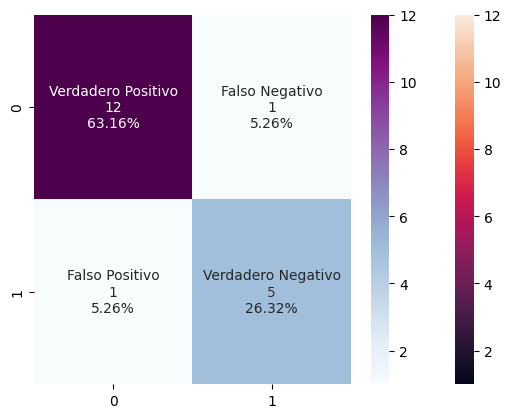

In [29]:
import seaborn as sns 
sns.heatmap(arr0, annot=True) 
#Clase 1 
# Seña “hola” 
group_names = ['Verdadero Positivo','Falso Negativo','Falso Positivo','Verdadero Negativo'] 
group_counts = ["{0:0.0f}".format(value) for value in 
    arr0.flatten()] 
group_percentages = ["{0:.2%}".format(value) for value in 
    arr0.flatten()/np.sum(arr0)] 
# 
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)] 
labels = np.asarray(labels).reshape(2,2) 
sns.heatmap(arr0, annot=labels, fmt='', cmap='BuPu') 
# 

<Axes: >

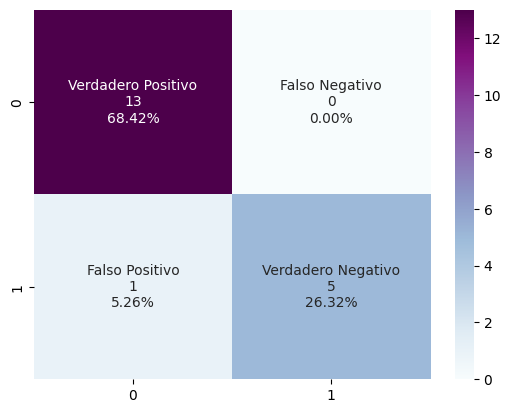

In [30]:
#Clase 2
# Seña “gracias” 
group_names = ['Verdadero Positivo','Falso Negativo','Falso Positivo','Verdadero Negativo'] 
group_counts = ["{0:0.0f}".format(value) for value in 
                arr1.flatten()] 
group_percentages = ["{0:.2%}".format(value) for value in 
                     arr1.flatten()/np.sum(arr1)] 
# 
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)] 
labels = np.asarray(labels).reshape(2,2) 
sns.heatmap(arr1, annot=labels, fmt='', cmap='BuPu')

<Axes: >

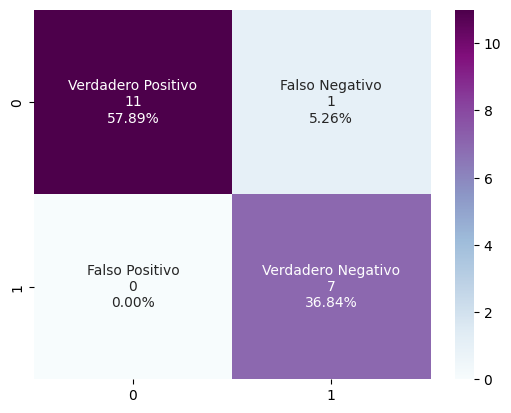

In [31]:
# Seña “isabel” 
group_names = ['Verdadero Positivo','Falso Negativo','Falso Positivo','Verdadero Negativo'] 
group_counts = ["{0:0.0f}".format(value) for value in 
    arr2.flatten()] 
group_percentages = ["{0:.2%}".format(value) for value in 
    arr2.flatten()/np.sum(arr2)] 
# 
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)] 
labels = np.asarray(labels).reshape(2,2) 
sns.heatmap(arr2, annot=labels, fmt='', cmap='BuPu') 
# 

<h2>PROBANDO EL MODELO AUMENTADO</h2>

In [8]:
# 1. Variables de detección 
sequence = [] # Recolecta los 30 frames para generar la predicción (Capturamos los frames y se lo pasamos al algoritmo)
sentence = []    # Nos permitirá concatenar nuestro historial de detección 
predictions = [] # Toma las (últimas 10) predicciones 
threshold = 0.9 # Métrica de confiabilidad según la cual se harán renders solo si los resultados están por encima de este valor

In [9]:
#para cargar el modelo
import tensorflow as tf
ruta_del_modelo = 'Modelo_Trad_Norm_Aug5.h5'  # Asegúrate de que la ruta sea correcta

try:
    model = tf.keras.models.load_model(ruta_del_modelo)
    print("Modelo cargado exitosamente.")
    model.summary()  # Opcional: muestra la arquitectura del modelo
except Exception as e:
    print(f"Error al cargar el modelo: {e}")

Modelo cargado exitosamente.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 30, 64)              │         442,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 30, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 30, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 630,823 (2.41 MB)

 Trainable params: 630,821 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [10]:
## Configurando Mediapipe Holistic 
# Variable para MPH: 
mp_holistic = mp.solutions.holistic 
# Variable para las drawing utilities de MP 
mp_drawing = mp.solutions.drawing_utils
def mediapipe_detection(image, model): 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image.flags.writeable = False 
    results = model.process(image)  
    image.flags.writeable = True 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results
    
def draw_hand_bbox(image, hand_landmarks):
    if hand_landmarks is None:
        return  # No hacer nada si no hay landmarks

    h, w, _ = image.shape
    coords = [(int(lm.x * w), int(lm.y * h)) for lm in hand_landmarks.landmark]
    
    x_vals = [pt[0] for pt in coords]
    y_vals = [pt[1] for pt in coords]
    
    min_x, max_x = min(x_vals), max(x_vals)
    min_y, max_y = min(y_vals), max(y_vals)

    # Dibuja el rectángulo
    cv2.rectangle(image, (min_x, min_y), (max_x, max_y), (255, 255, 0), 2)


In [10]:
def draw_changed_landmarks(image, results): 
    # Para dibujar los landmarks de la cara (con sus conexiones) 
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, mp_drawing.DrawingSpec(color=(191,95,0), thickness=1, circle_radius=1), mp_drawing.DrawingSpec(color=(237,178,101), thickness=1, circle_radius=0.5))  
    
    # Para dibujar los landmarks de la postura (con sus conexiones) 
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(3,56,172), thickness=2, circle_radius=3), mp_drawing.DrawingSpec(color=(141,241,244), thickness=2, circle_radius=3))  
    
    # Para dibujar los landmarks de la mano izquierda (con sus conexiones) 
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, mp_drawing.DrawingSpec(color=(3,89,17), thickness=2, circle_radius=3), mp_drawing.DrawingSpec(color=(134,242,196), thickness=3, circle_radius=2)) 

    # Dibujar bounding box
    draw_hand_bbox(image, results.left_hand_landmarks)
    
     # Para dibujar los landmarks de la mano derecha (con sus conexiones) 
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, mp_drawing.DrawingSpec(color=(134,242,196), thickness=2, circle_radius=3), mp_drawing.DrawingSpec(color=(3,89,17), thickness=3, circle_radius=2)) 

    # Dibujar bounding box
    draw_hand_bbox(image, results.right_hand_landmarks)

def normalize_hand_landmarks(hand_landmarks, image_shape):
    if hand_landmarks is None:
        return np.zeros(21 * 3)
    
    h, w, _ = image_shape
    coords = np.array([[lm.x * w, lm.y * h, lm.z * w] for lm in hand_landmarks.landmark])

    x_min, y_min = coords[:, 0].min(), coords[:, 1].min()
    x_max, y_max = coords[:, 0].max(), coords[:, 1].max()

    width = x_max - x_min
    height = y_max - y_min

    # Evita división por cero
    if width == 0 or height == 0:
        return np.zeros(21 * 3)

    # Normaliza entre 0 y 1 dentro del bounding box
    coords[:, 0] = (coords[:, 0] - x_min) / width
    coords[:, 1] = (coords[:, 1] - y_min) / height
    coords[:, 2] = coords[:, 2] / w  # mantén z relativa al ancho

    return coords.flatten()
#verrrr
def extract_keypoints(results, image_shape): 
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4) 
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)  
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)  
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3) 

    return np.concatenate([pose, face, lh, rh])

def extract_keypoints_normalized(results, image_shape): 
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4) 
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)  
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)  
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3) 

    # Normalizados los datos de las manos
    lh_normalized = normalize_hand_landmarks(results.left_hand_landmarks, image_shape) if results.left_hand_landmarks else np.zeros(21*3)
    rh_normalized = normalize_hand_landmarks(results.right_hand_landmarks, image_shape) if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh_normalized, rh_normalized])

In [11]:
# Implementación del modelo de predicción 
cap = cv2.VideoCapture(0) 
#Para acceder al modelo mediapipe

# configurando el modelo mediapipe: 
with mp_holistic.Holistic(min_detection_confidence=0.8, min_tracking_confidence=0.6) as holistic: 
    while cap.isOpened():
        #Leyendo el feed 
        ret, frame = cap.read() #Cuando leemos obtenemos estos dos valores return y frame (la img de la cámara) 
        #
         #Detección 
        image, results = mediapipe_detection(frame, holistic) 
        print(results)      
        #
        #Dibujar landmarks (entre la detección y el display) 
        draw_changed_landmarks(image, results) 
        #    
         #2. Predicción 
        image_shape = image.shape
        keypoints = extract_keypoints(results, image_shape)
        sequence.append(keypoints) 
        sequence = sequence[-30:] # se toman los últimos 30 frames para hacer la predicción correspondiente 
        #
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0] 
            print(actions[np.argmax(res)]) 
            predictions.append(np.argmax(res)) 
            #
            #3. Lógica de visualización 
            if np.unique(predictions[-8:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                #
                    if len(sentence) > 0: # Revisa si se tienen palabras en el arreglo 'sentence', si no: (*)
                        if actions[np.argmax(res)] != sentence[-1]: 
                            sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])  
            if len(sentence) > 5: 
                sentence = sentence[-5:] # se toman los últimos 5 valores 
                cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1) #-1 significa que llena el rectángulo
                cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA) 
                cv2.imshow('Pantalla OpenCV', image) # antes cv2.imshow('OpenCV Feed', frame) porque hacía rendering del frame  
        if cv2.waitKey(10) & 0xFF == (ord('q')): 
            break 
    cap.release() 
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

NameError: name 'actions' is not defined

In [45]:
# Implementación del modelo de predicción 
cap = cv2.VideoCapture(0) 
#Para acceder al modelo mediapipe
# configurando el modelo mediapipe: 
with mp_holistic.Holistic(min_detection_confidence=0.8, min_tracking_confidence=0.6) as holistic: 
    while cap.isOpened(): 
# 
        #Leyendo el feed 
        ret, frame = cap.read() #Cuando leemos obtenemos estos dos valores return y frame (la img de la cámara) 
    # 
        #Detección 
        image, results = mediapipe_detection(frame, holistic) 
        print(results) 
    #
        #Dibujar landmarks (entre la detección y el display) 
        draw_changed_landmarks(image, results) 
    #
        #2. Predicción 
        keypoints = extract_keypoints(results) 
        sequence.append(keypoints) 
        sequence = sequence[-30:] # se toman los últimos 30 frames para hacer la predicción correspondiente 
    #
        if len(sequence) == 30: 
            res = model.predict(np.expand_dims(sequence, axis=0))[0] 
            print(actions[np.argmax(res)]) 
            predictions.append(np.argmax(res)) 
            #
        #3. Logica de visualizacion
            if np.unique(predictions[-8:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
    # 
                    if len(sentence) > 0:          # Revisa si se tienen palabras en el arreglo 'sentence', si no: (*) 
                        if actions[np.argmax(res)] != sentence[-1]: 
                            sentence.append(actions[np.argmax(res)]) 
                    else:     
                         sentence.append(actions[np.argmax(res)])    # (*) append 
                        
    # 
            if len(sentence) > 3: 
                sentence = sentence[-3:] # se toman los últimos 5 valores 
    #           
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1) #-1 significa que llena el rectángulo 
        cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA) #para renderizar la oración
        #Presentar en pantalla 
        cv2.imshow('Pantalla OpenCV', image) # antes cv2.imshow('OpenCV Feed', frame) porque hacía rendering del frame  
    # 
        #Para la "current key", sale del loop 
        if cv2.waitKey(1) & 0xFF == ((ord('q')) or ((ord('Q')))): 
            break 
    cap.release() 
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Gracias
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Gracias
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Gracias
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Gracias
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Gracias
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Gracias
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Gracias
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Gracias
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Gracias
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━

<h2>GRAFICANDO</h2>


Generando gráficas de accuracy y loss...


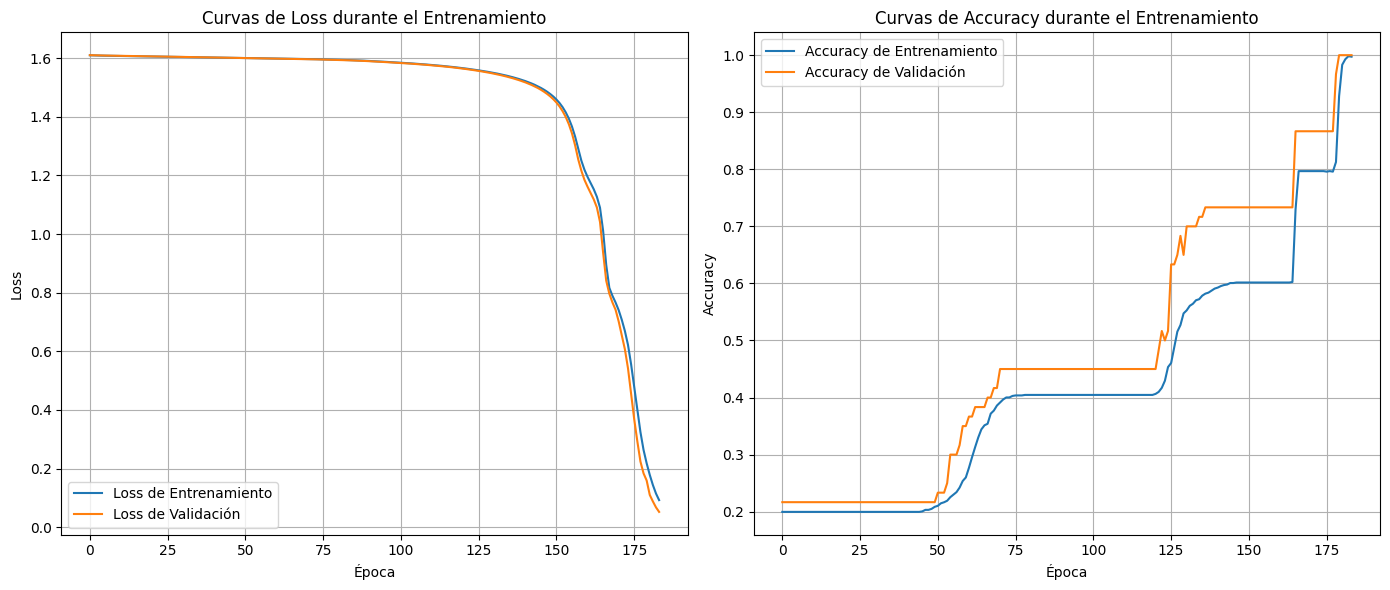

Gráficas generadas.

Evaluando el modelo en el conjunto de prueba...
Loss en el conjunto de prueba: 0.0796
Accuracy (categorical) en el conjunto de prueba: 1.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

--- Métricas de Clasificación ---
Reporte de Clasificación:
              precision    recall  f1-score   support

        Hola       1.00      1.00      1.00        11
     Gracias       1.00      1.00      1.00        12
   Comprendo       1.00      1.00      1.00        13
  Como estas       1.00      1.00      1.00         5
     De nada       1.00      1.00      1.00        22

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63


Matriz de Confusión:
[[11  0  0  0  0]
 [ 0 12  0  0  0]
 [ 0  0 13  0  0]
 [ 0  0  0  5  0]
 [ 0  0  0  0 22]]

Accuracy General: 1.0000
Precision General (ponderada): 1.0000
Recall General (ponderado): 1.0000
F1-Score General (ponderado): 1.0000


In [15]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
# --- 1. Gráficas de Accuracy y Loss durante el entrenamiento ---
print("\nGenerando gráficas de accuracy y loss...")
plt.figure(figsize=(14, 6))

# Gráfica de Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss de Entrenamiento')
if 'val_loss' in history.history: # Verifica si hay datos de validación
    plt.plot(history.history['val_loss'], label='Loss de Validación')
plt.title('Curvas de Loss durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Gráfica de Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Accuracy de Entrenamiento')
if 'val_categorical_accuracy' in history.history: # Verifica si hay datos de validación
    plt.plot(history.history['val_categorical_accuracy'], label='Accuracy de Validación')
plt.title('Curvas de Accuracy durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
print("Gráficas generadas.")

# --- 2. Evaluación del modelo y Métricas Adicionales ---
print("\nEvaluando el modelo en el conjunto de prueba...")
# Evaluar el modelo en el conjunto de prueba
# La función evaluate devuelve la pérdida y las métricas que definiste en compile
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss en el conjunto de prueba: {loss:.4f}')
print(f'Accuracy (categorical) en el conjunto de prueba: {accuracy:.4f}')

# Realizar predicciones en el conjunto de prueba
y_pred_proba = model.predict(X_test)
# Convertir probabilidades a clases (el índice de la clase con la mayor probabilidad)
y_pred = np.argmax(y_pred_proba, axis=1)

# Las etiquetas reales también deben estar en formato de índice (no one-hot encoded) para sklearn.metrics
y_true = np.argmax(y_test, axis=1)

print("\n--- Métricas de Clasificación ---")
print("Reporte de Clasificación:")
# target_names es útil para ver las métricas por cada clase
print(classification_report(y_true, y_pred, target_names=actions.astype(str)))

print("\nMatriz de Confusión:")
# La matriz de confusión muestra el número de predicciones correctas e incorrectas por clase
print(confusion_matrix(y_true, y_pred))

# Calcular métricas adicionales de forma individual (usando 'weighted' o 'macro' para multiclase)
# 'weighted': considera el desbalance de clases.
# 'macro': calcula métricas para cada clase y toma el promedio sin considerar el desbalance.
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"\nAccuracy General: {acc:.4f}")
print(f"Precision General (ponderada): {precision:.4f}")
print(f"Recall General (ponderado): {recall:.4f}")
print(f"F1-Score General (ponderado): {f1:.4f}")

# Puedes acceder al historial de entrenamiento de forma más directa si lo necesitas
# print("\nHistorial completo de entrenamiento:")
# for key, value in history.history.items():
#     print(f"{key}: {value}")

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os # Solo si necesitas cargar archivos

# Asumiendo que las funciones de data augmentation, __random_pass, etc. ya están definidas
# y que tienes los paths correctos a tus datos.

# Conexiones estándar de MediaPipe para los 21 landmarks de la mano
hand_connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),  # Pulgar
    (0, 5), (5, 6), (6, 7), (7, 8),  # Índice
    (0, 9), (9, 10), (10, 11), (11, 12), # Medio
    (0, 13), (13, 14), (14, 15), (15, 16), # Anular
    (0, 17), (17, 18), (18, 19), (19, 20)  # Meñique
]

def plot_hand_landmarks(ax, landmarks, title="", color='blue'):
    """
    Dibuja los landmarks de una mano en un eje 2D (solo X e Y).
    
    Args:
        ax (matplotlib.axes.Axes): El eje de Matplotlib donde dibujar.
        landmarks (np.array): Array de 21x3 con los keypoints (x, y, z).
        title (str): Título para el gráfico.
        color (str): Color de los puntos y líneas.
    """
    # Dibuja los puntos
    ax.scatter(landmarks[:, 0], landmarks[:, 1], c=color, s=50, label='Keypoints')
    
    # Dibuja las conexiones
    for connection in hand_connections:
        p1_idx, p2_idx = connection
        ax.plot([landmarks[p1_idx, 0], landmarks[p2_idx, 0]],
                [landmarks[p1_idx, 1], landmarks[p2_idx, 1]],
                c=color, linewidth=2)
    
    ax.set_title(title)
    ax.set_xlabel("X Coordenada")
    ax.set_ylabel("Y Coordenada")
    ax.set_aspect('equal', adjustable='box') # Mantiene la proporción de los ejes


def visualize_augmentation(original_keypoints_path, augmented_keypoints_path):
    """
    Carga un frame original y su versión aumentada, y los visualiza lado a lado.
    Asegura que todas las gráficas tengan la misma escala.
    """
    try:
        original_data = np.load(original_keypoints_path)
        augmented_data = np.load(augmented_keypoints_path)
    except FileNotFoundError:
        print(f"Error: Archivo no encontrado. Original: {original_keypoints_path}, Aumentado: {augmented_keypoints_path}")
        return

    # Extraer landmarks de manos (igual que en apply_hand_data_augmentation)
    lh_start = 33 * 4 + 468 * 3
    lh_end = lh_start + 21 * 3
    rh_start = lh_end
    rh_end = rh_start + 21 * 3

    original_lh_landmarks = original_data[lh_start:lh_end].reshape(21, 3) if original_data.shape[0] >= rh_end else None
    original_rh_landmarks = original_data[rh_start:rh_end].reshape(21, 3) if original_data.shape[0] >= rh_end else None

    augmented_lh_landmarks = augmented_data[lh_start:lh_end].reshape(21, 3) if augmented_data.shape[0] >= rh_end else None
    augmented_rh_landmarks = augmented_data[rh_start:rh_end].reshape(21, 3) if augmented_data.shape[0] >= rh_end else None

    # --- Calcular límites globales para X e Y ---
    all_x = []
    all_y = []

    for hand_landmarks in [original_lh_landmarks, original_rh_landmarks, augmented_lh_landmarks, augmented_rh_landmarks]:
        if hand_landmarks is not None:
            all_x.extend(hand_landmarks[:, 0])
            all_y.extend(hand_landmarks[:, 1])

    if not all_x or not all_y: # Si no se detectó ninguna mano, no hay nada que graficar
        print("No se detectaron landmarks de manos en los archivos proporcionados.")
        return

    min_x, max_x = np.min(all_x), np.max(all_x)
    min_y, max_y = np.min(all_y), np.max(all_y)

    # Añadir un pequeño margen para que los landmarks no toquen los bordes
    padding_x = (max_x - min_x) * 0.1
    padding_y = (max_y - min_y) * 0.1
    
    global_xlim = (min_x - padding_x, max_x + padding_x)
    global_ylim = (min_y - padding_y, max_y + padding_y)


    # Crear la figura con subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle('Visualización de Data Augmentation de Manos', fontsize=16)

    # Lista de ejes para aplicar los límites globales
    all_axes = [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]

    # Plotear mano izquierda original
    if original_lh_landmarks is not None:
        plot_hand_landmarks(axes[0, 0], original_lh_landmarks, "Mano Izquierda Original", color='red')
    else:
        axes[0, 0].set_title("Mano Izquierda Original (No Detectada)")
        axes[0, 0].text(0.5, 0.5, "No hay mano", horizontalalignment='center', verticalalignment='center', transform=axes[0, 0].transAxes)

    # Plotear mano izquierda aumentada
    if augmented_lh_landmarks is not None:
        plot_hand_landmarks(axes[0, 1], augmented_lh_landmarks, "Mano Izquierda Aumentada", color='blue')
    else:
        axes[0, 1].set_title("Mano Izquierda Aumentada (No Detectada)")
        axes[0, 1].text(0.5, 0.5, "No hay mano", horizontalalignment='center', verticalalignment='center', transform=axes[0, 1].transAxes)

    # Plotear mano derecha original
    if original_rh_landmarks is not None:
        plot_hand_landmarks(axes[1, 0], original_rh_landmarks, "Mano Derecha Original", color='red')
    else:
        axes[1, 0].set_title("Mano Derecha Original (No Detectada)")
        axes[1, 0].text(0.5, 0.5, "No hay mano", horizontalalignment='center', verticalalignment='center', transform=axes[1, 0].transAxes)

    # Plotear mano derecha aumentada
    if augmented_rh_landmarks is not None:
        plot_hand_landmarks(axes[1, 1], augmented_rh_landmarks, "Mano Derecha Aumentada", color='blue')
    else:
        axes[1, 1].set_title("Mano Derecha Aumentada (No Detectada)")
        axes[1, 1].text(0.5, 0.5, "No hay mano", horizontalalignment='center', verticalalignment='center', transform=axes[1, 1].transAxes)

    # --- Aplicar límites globales a todos los ejes ---
    for ax in all_axes:
        ax.set_xlim(global_xlim)
        ax.set_ylim(global_ylim)
        ax.grid(True, linestyle='--', alpha=0.6) # Mantener la cuadrícula

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [34]:
DATA_PATH_AUG = os.path.join('Datos_Dataset_Aug_AllFour')

Visualizando Frame 25:
Original: Datos_Dataset_Normalized_3\Comprendo\124\25.npy
Aumentado: Datos_Dataset_Aug_AllFour\Comprendo\249\25.npy


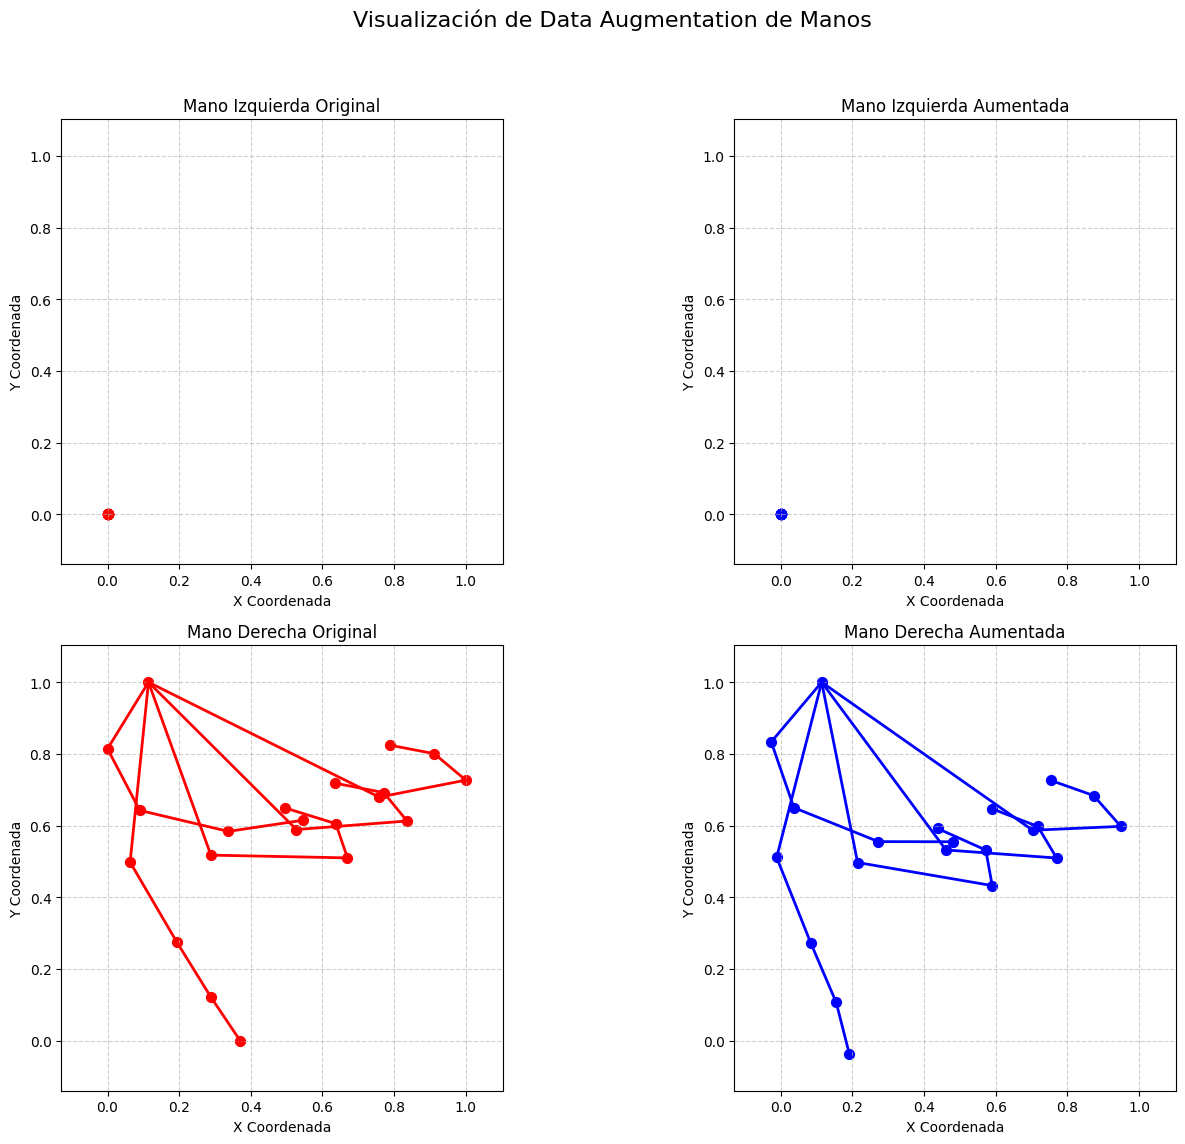

In [35]:
# Asegúrate de tener los paths correctos a tus carpetas
#DATA_PATH = 'Datos_Dataset' # Tu carpeta con las secuencias originales
#AUGMENTED_DATA_PATH = 'Datos_Dataset' # Donde guardaste las aumentadas

action_name = 'Comprendo'
original_sequence_num = 124
# Si tus secuencias aumentadas empiezan en 125, por ejemplo:
augmented_sequence_num = original_sequence_num + 125
frame_to_visualize = 25 # Elige un número de frame, por ejemplo, el frame 5 de la secuencia

original_frame_path = os.path.join(DATA_PATH_NORM,action_name, str(original_sequence_num), f'{frame_to_visualize}.npy')
augmented_frame_path = os.path.join(DATA_PATH_AUG, action_name, str(augmented_sequence_num), f'{frame_to_visualize}.npy')

print(f"Visualizando Frame {frame_to_visualize}:")
print(f"Original: {original_frame_path}")
print(f"Aumentado: {augmented_frame_path}")

visualize_augmentation(original_frame_path, augmented_frame_path)